# Business Problem

## Business context: The data from a credit card processor shows the consumer types and their business spending behaviours. Therefore, companies can develop the marketing campaigns that directly address consumers’ behaviour. In return, this helps to make better sales and the revenue undoubtedly growsgreater sales.

## Understanding the consumption pattern for credit cards at an individual consumer level is important for customer relationship management. This understanding allows banks to customize for consumers and make strategic marketing plans. Thus it is imperative to study the relationship between the characteristics of the consumers and their consumption patterns.

#### Note: Some customers are having missing values for credit consumption. You need to build the model using customer’s data where credit consumption is non- missing’s. You need to predict the credit consumption for next three months for the customers having missing values.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

#!pip install pandas_profiling 
#import pandas_profiling 
import scipy.stats as stats
import statsmodels as sm
%matplotlib inline

import pandas_profiling

import sklearn as sk
from sklearn import metrics

plt.rcParams['figure.figsize'] = 6, 4
plt.rcParams['axes.grid'] = True

#These will help you to see all records as well as columns in the data set
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


C:\Users\Vicky\anaconda31\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Vicky\anaconda31\lib\site-packages\numpy\.libs\libopenblas.QVLO2T66WEPI7JZ63PS3HMOHFEY472BC.gfortran-win_amd64.dll
C:\Users\Vicky\anaconda31\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

In [4]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [5]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [6]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    else:
        x = x.fillna(x.mode().iloc[0])
    return x

In [7]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

# Import DataSets

In [8]:
credit_consum=pd.read_excel('CreditConsumptionData.xlsx',engine = 'openpyxl')  # Credit consumption data
credit_demo=pd.read_excel('CustomerDemographics.xlsx',engine = 'openpyxl')   # Customers demographics data
credit_behav=pd.read_excel('CustomerBehaviorData.xlsx', engine = 'openpyxl')  # Customers Behavior data
 

# Merging datasets

In [9]:
df = pd.merge(credit_consum,credit_demo, on = 'ID', how ='inner' )
final_data= pd.merge(df,credit_behav, on = 'ID', how ='inner' )
final_data

,ID,cc_cons,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
0,12554,20014.0,current,M,35,MEDIUM,15.0,1,708.0,0,17.0,24893.000,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26,10,48,14,47,430000,1,1,1.0,1,593.20,1244.14,787.0,6885.0,85919.48,25192.00,24.0,6,25296.0,11527.50,191777.13,2,40,24563.0,30051.32,12761.00,2,65,50836.0,Y,1674.09
1,17645,10173.0,current,M,35,HIGH,15.0,6,123.0,0,14.0,18941.620,966.00,20672.00,287.00,4217.00,885.00,1.0,7,13,3,21,31,127500,1,1,1.0,1,213557.15,172678.56,90525.0,1500.0,12255.75,88693.37,35.0,36,80750.0,92276.57,71162.00,2,78,23948.0,42119.05,76206.00,21,63,23226.0,Y,13043.34
2,7604,16095.0,current,M,55,MEDIUM,24.5,1,802.0,1,3.0,5678.870,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32,102,4,1,80,199999,1,1,1.0,1,165907.57,470000.00,25524.0,3735.0,34193.00,84880.00,72.0,9,38466.0,19343.00,70978.00,2,82,10752.0,58373.25,75283.00,7,1,27036.0,Y,25375.27
3,1590,7707.0,current,F,29,MEDIUM,4.5,6,867.0,1,4.0,30489.500,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1,50,1,1,10,155000,1,1,1.0,1,81872.65,223379.40,48500.0,-4679.0,11558.23,236326.00,43.0,30,52732.0,43867.91,63033.84,23,38,12607.0,69851.51,68708.00,21,83,43037.0,Y,3544.33
4,16556,96408.0,current,M,34,MEDIUM,12.6,4,802.0,1,7.0,7441.400,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47,82,54,16,68,297000,1,1,1.0,1,568.80,385000.00,183999.0,6916.0,17022.81,58897.03,46.0,36,19613.0,153253.71,30286.00,24,50,25213.0,10071.00,80140.00,8,32,32044.0,NaN,12780.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,12512,NaN,current,M,35,MEDIUM,13.5,1,523.0,0,7.0,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,4,1,2,26,595000,1,1,1.0,1,84446.00,961916.90,492.0,553.0,41314.91,37646.41,6.0,14,27825.0,34952.75,45461.00,35,11,32944.0,105488.53,125470.83,21,50,58037.0,Y,7870.88
19996,14224,NaN,current,M,53,MEDIUM,9.9,7,723.0,1,2.0,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,50,18,1,58,13000,1,1,1.0,1,1892440.00,295150.90,10271.0,20324.0,216.25,1605.00,32.0,26,27912.0,17261.41,85422.00,5,8,8850.0,77112.66,86559.00,62,38,24110.0,Y,3668.30
19997,18740,NaN,current,M,62,HIGH,37.8,8,863.0,1,16.0,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,1,1,2,17,124000,1,1,1.0,1,115.45,200015.58,30000.0,6885.0,89327.00,80044.00,32.0,14,14580.0,142002.00,68985.86,10,108,35819.0,57192.48,80627.00,2,18,1769.0,Y,5450.34
19998,18134,NaN,current,M,34,MEDIUM,12.6,4,882.0,0,13.0,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,4,1,44,67,371000,1,1,1.0,1,48796.45,1631.11,925.0,10455.0,191780.00,66057.00,40.0,5,23881.0,156995.05,13558.00,11,12,39083.0,82039.00,24332.00,117,64,37255.0,Y,59.29


In [10]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons                       15000 non-null  float64
 2   account_type                  19999 non-null  object 
 3   gender                        19999 non-null  object 
 4   age                           20000 non-null  int64  
 5   Income                        19999 non-null  object 
 6   Emp_Tenure_Years              20000 non-null  float64
 7   Tenure_with_Bank              20000 non-null  int64  
 8   region_code                   19999 non-null  float64
 9   NetBanking_Flag               20000 non-null  int64  
 10  Avg_days_between_transaction  19997 non-null  float64
 11  cc_cons_apr                   20000 non-null  float64
 12  dc_cons_apr                   20000 non-null  float64
 13  c

In [11]:
 ## Non missing data according to CC_cons, as we will predict CC_Cons on missing data so seperate the nonmissing and missing 
    # on the basis of cc_cons

In [12]:
#credit_spend = final_data[-final_data.cc_cons.isna()] 
credit_spend_existing = final_data[final_data.cc_cons.isnull()==0]
credit_spend_new = final_data[final_data.cc_cons.isnull()==1]

In [13]:
# Now we have two datasets namely credit_spend_existing on which model will be build and credit_spend_new on which 
# we will find cc_cons for our new datasets

# Data exploratory analysis and Data understanding


In [14]:
import pandas as pd
print(pd.__version__)

1.3.2


In [15]:
credit_spend_existing.info()   # data understanding using .info(), .shape , univariate , bivariate analysis

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 0 to 14999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            15000 non-null  int64  
 1   cc_cons                       15000 non-null  float64
 2   account_type                  15000 non-null  object 
 3   gender                        15000 non-null  object 
 4   age                           15000 non-null  int64  
 5   Income                        15000 non-null  object 
 6   Emp_Tenure_Years              15000 non-null  float64
 7   Tenure_with_Bank              15000 non-null  int64  
 8   region_code                   15000 non-null  float64
 9   NetBanking_Flag               15000 non-null  int64  
 10  Avg_days_between_transaction  14999 non-null  float64
 11  cc_cons_apr                   15000 non-null  float64
 12  dc_cons_apr                   15000 non-null  float64
 13  c

In [16]:
# '''As we have to predict credit consumption means credit spend by the customer that is our target variable, 
#that will be a numeric value so that this is a regression problem. 


In [17]:
credit_spend_existing.shape    # no. of rows and columns

(15000, 49)

In [18]:
print(list(credit_spend_existing.columns))

['ID', 'cc_cons', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'loan_enq', 'emi_active']


In [19]:
#All columns names are right no need to renaming using .rename if there are some space or any special char then we will remove
# that

## Univariate Analysis: 
#### Univariate major purpose is to describe; It takes data, summarizes that data and finds patterns in the data and to see distribution of variables.

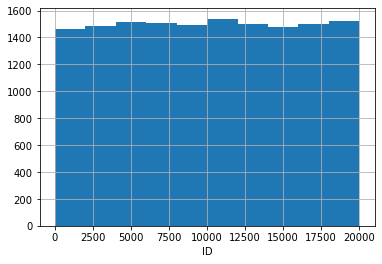

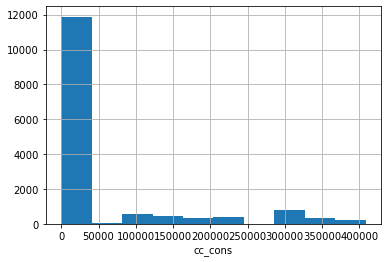

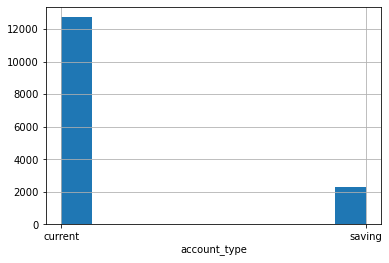

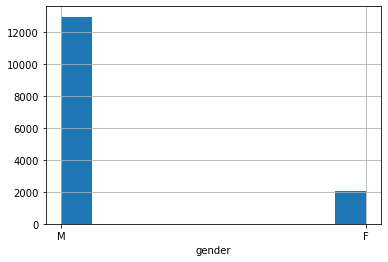

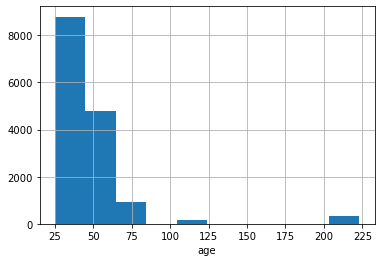

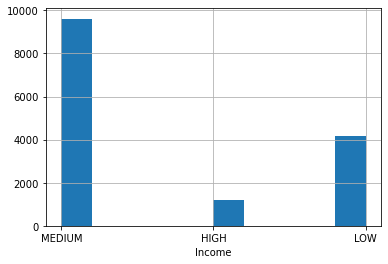

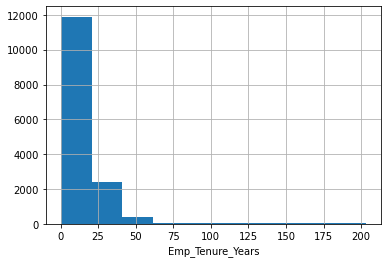

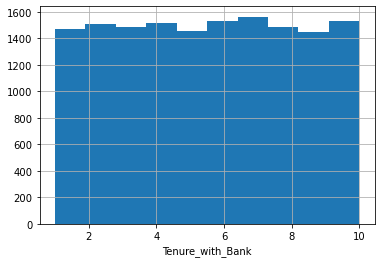

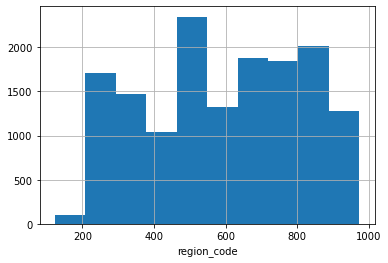

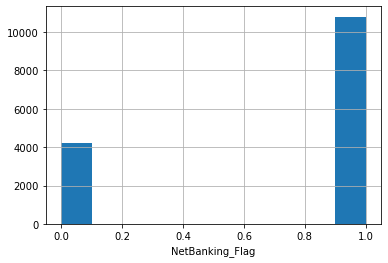

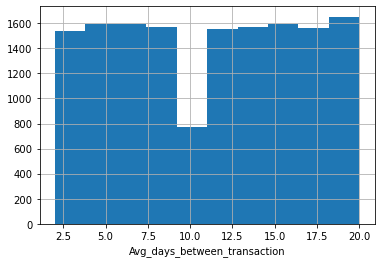

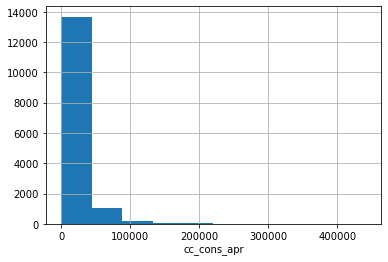

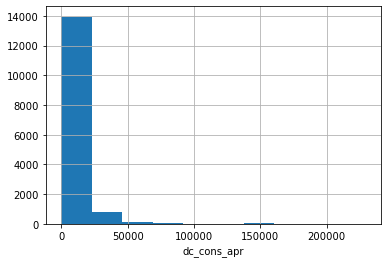

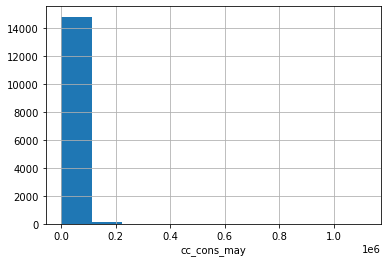

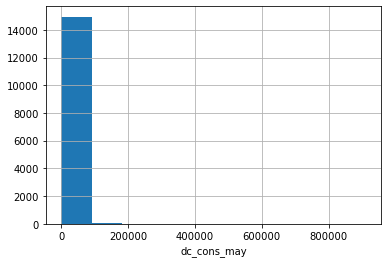

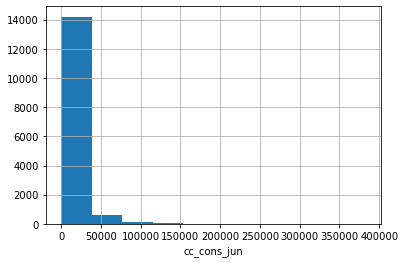

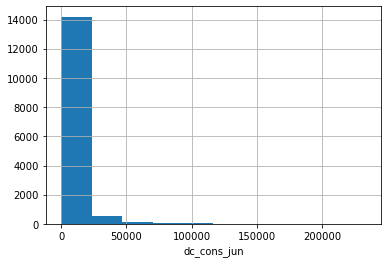

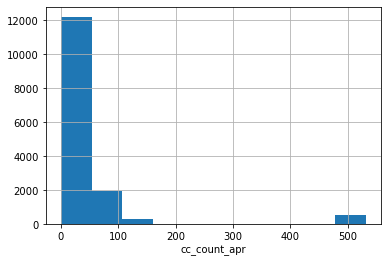

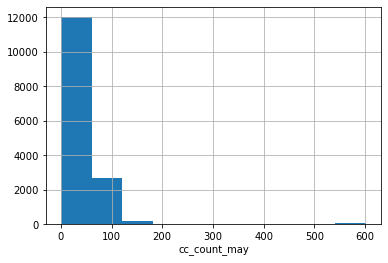

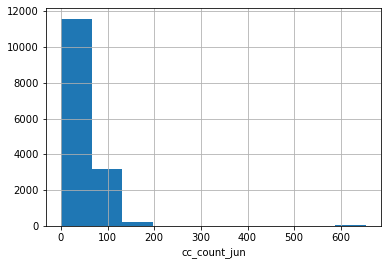

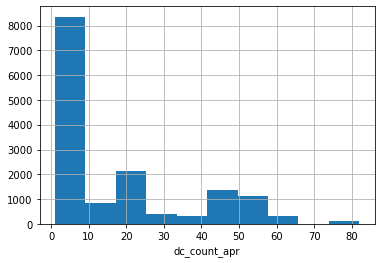

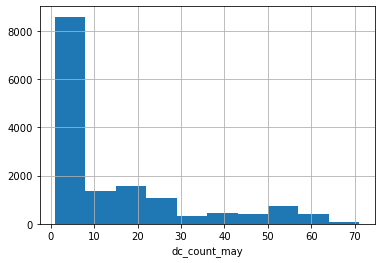

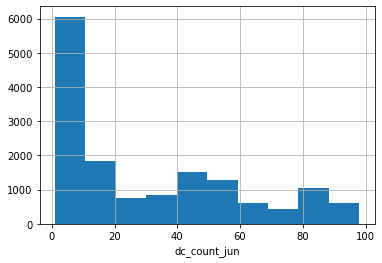

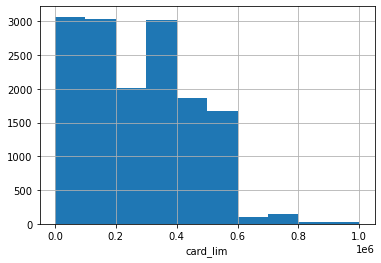

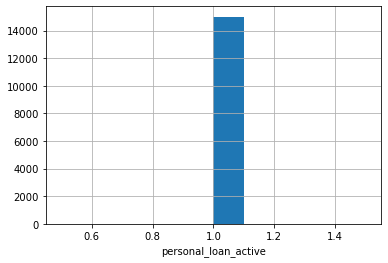

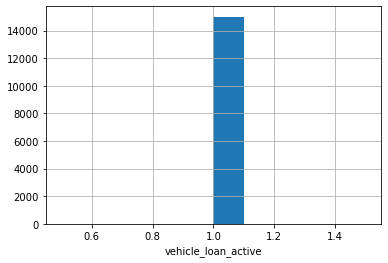

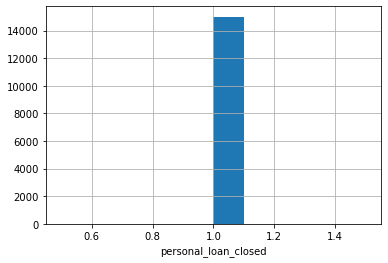

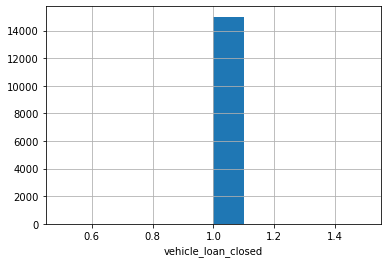

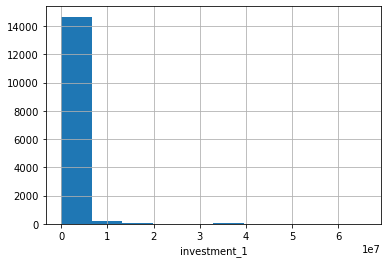

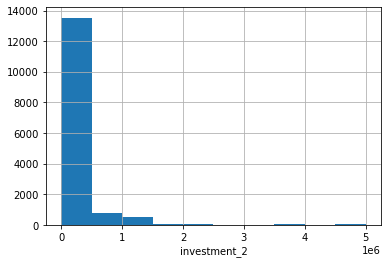

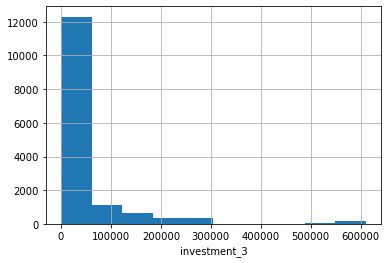

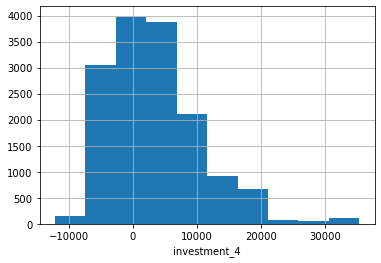

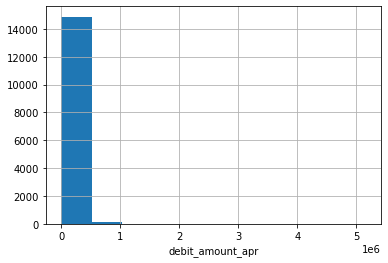

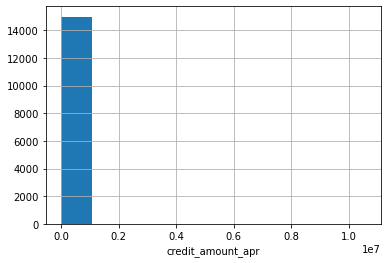

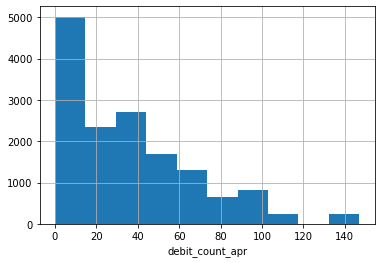

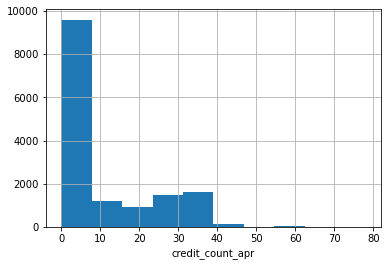

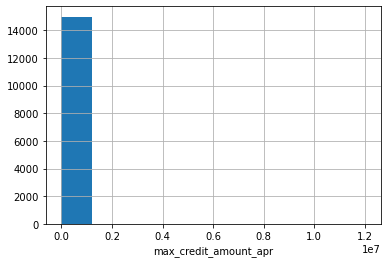

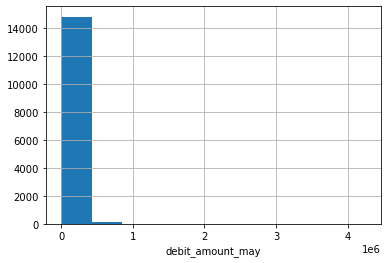

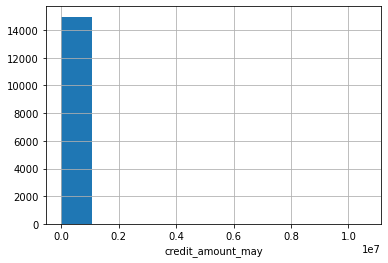

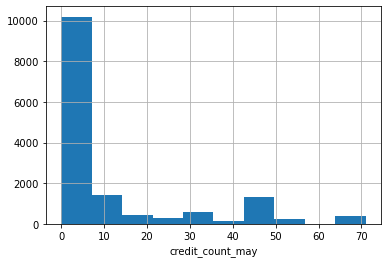

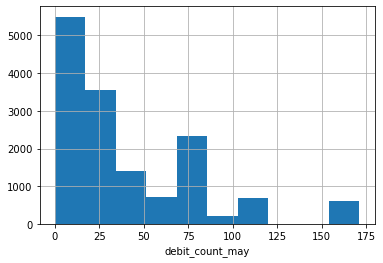

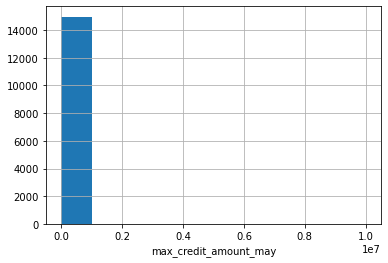

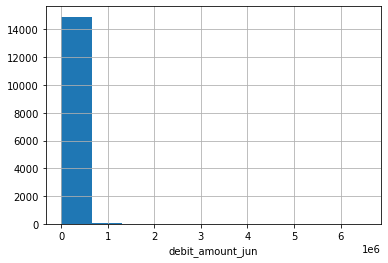

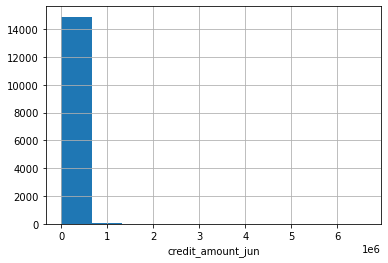

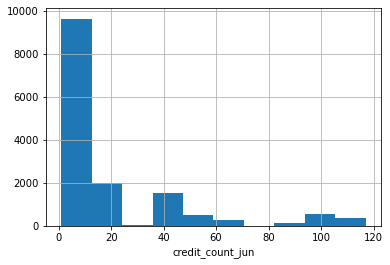

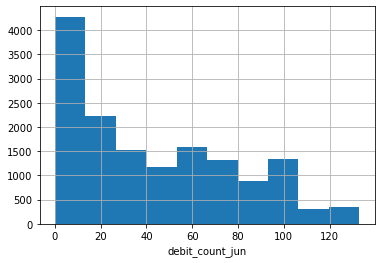

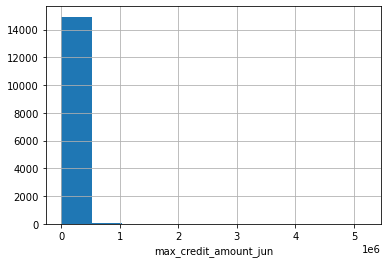

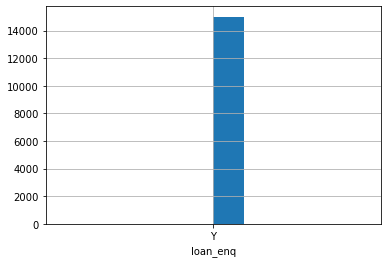

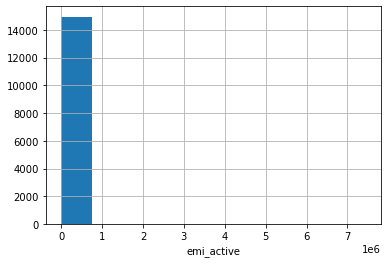

In [20]:
for i in credit_spend_existing.columns:
    credit_spend_existing[i].hist()
    plt.xlabel(str(i))
    plt.show()

In [21]:
credit_spend_existing.nunique()

ID                              15000
cc_cons                         12260
account_type                        2
gender                              2
age                                43
Income                              3
Emp_Tenure_Years                  270
Tenure_with_Bank                   10
region_code                       210
NetBanking_Flag                     2
Avg_days_between_transaction       19
cc_cons_apr                      7408
dc_cons_apr                      3638
cc_cons_may                      7461
dc_cons_may                      3786
cc_cons_jun                      6525
dc_cons_jun                      2874
cc_count_apr                       50
cc_count_may                       58
cc_count_jun                       67
dc_count_apr                       41
dc_count_may                       39
dc_count_jun                       54
card_lim                          308
personal_loan_active                1
vehicle_loan_active                 1
personal_loa

## Bivariate Analysis
#### It involves the analysis of two variables, for the purpose of determining the empirical relationship between them. 


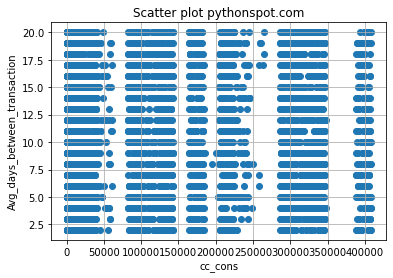

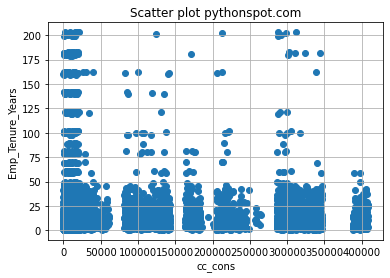

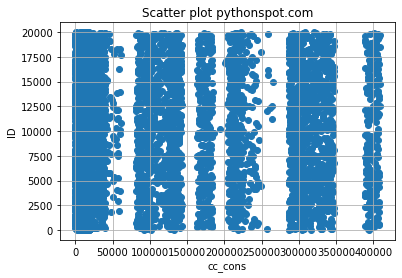

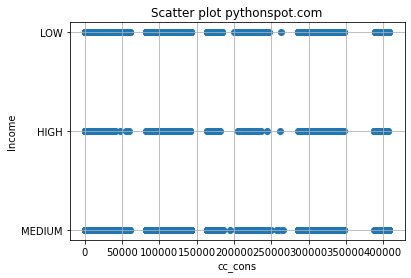

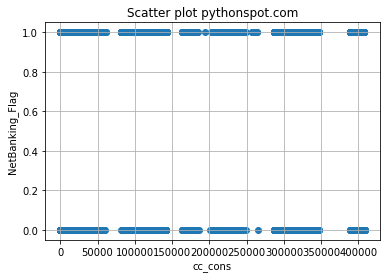

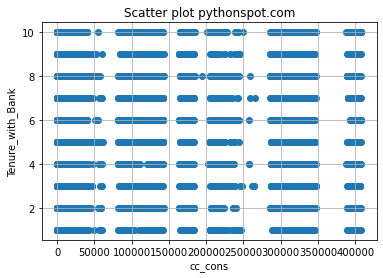

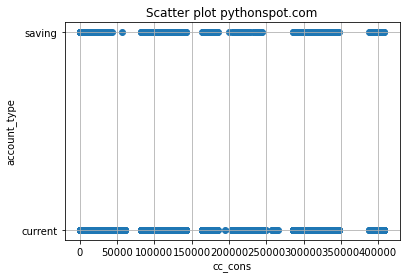

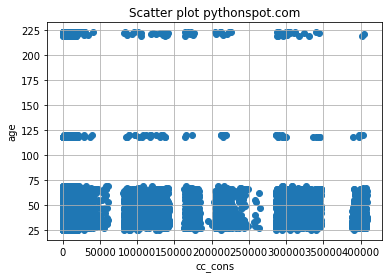

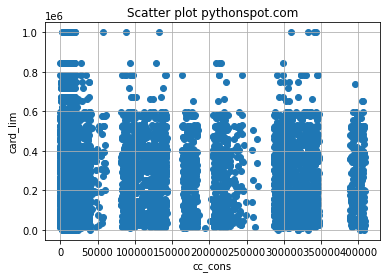

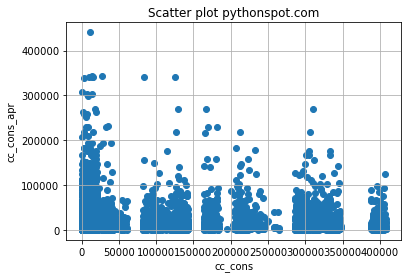

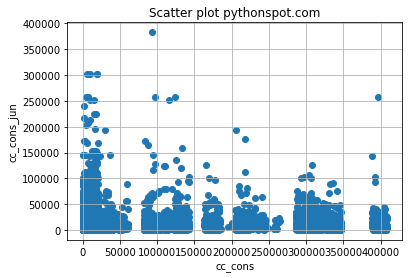

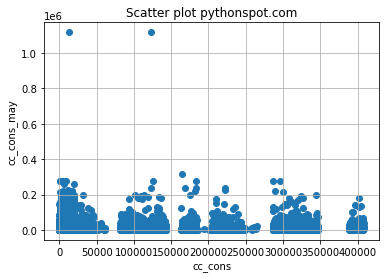

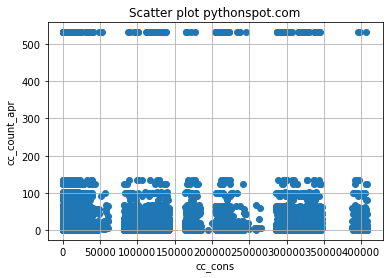

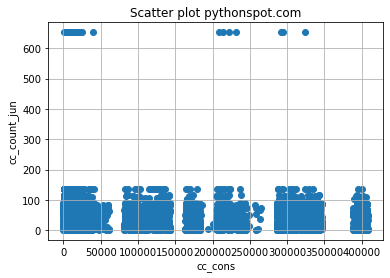

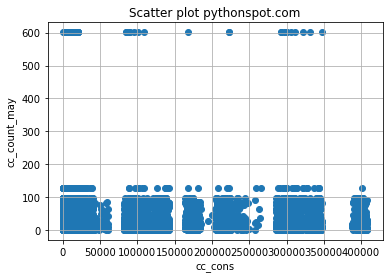

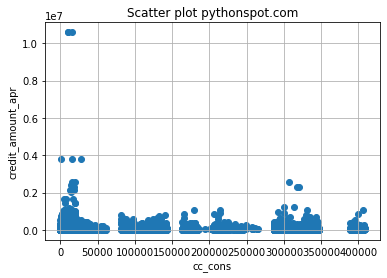

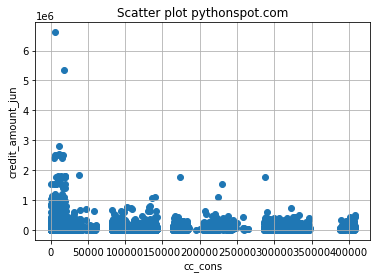

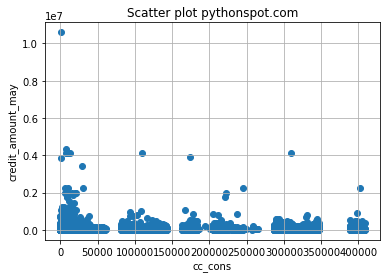

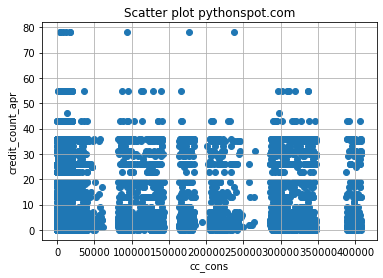

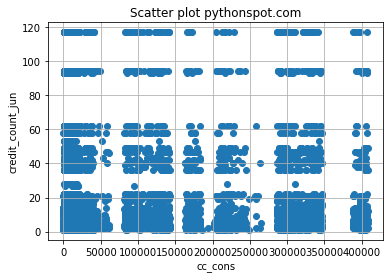

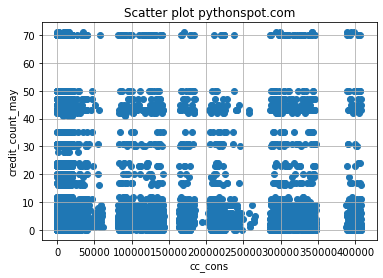

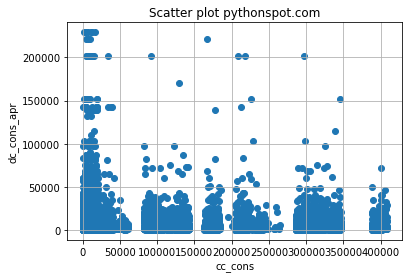

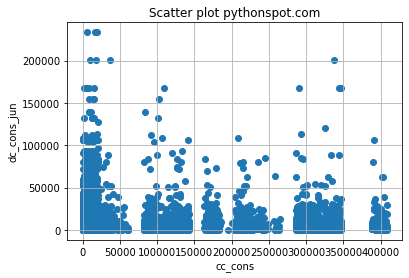

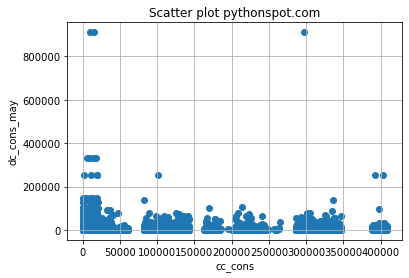

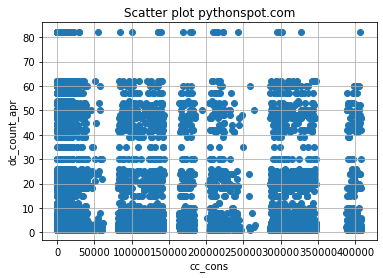

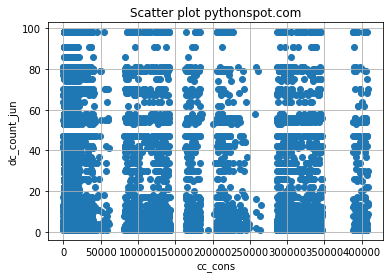

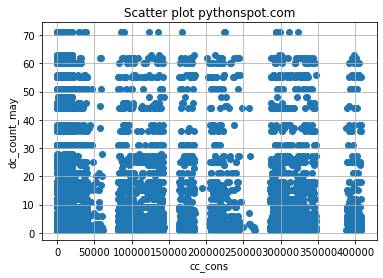

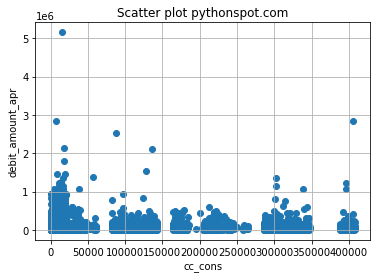

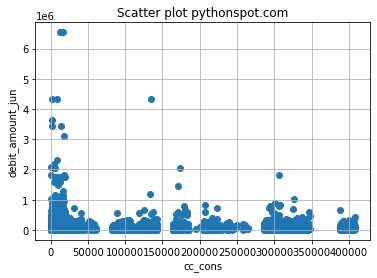

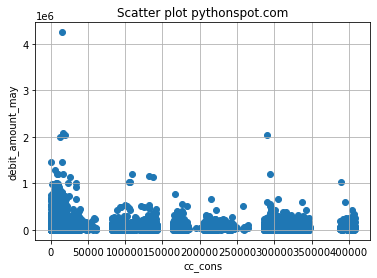

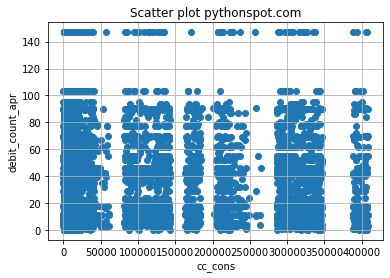

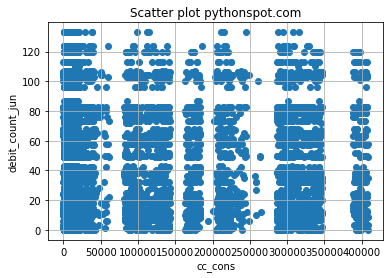

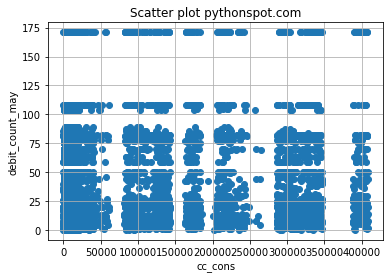

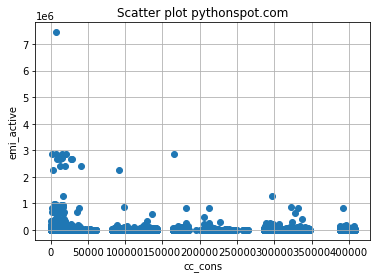

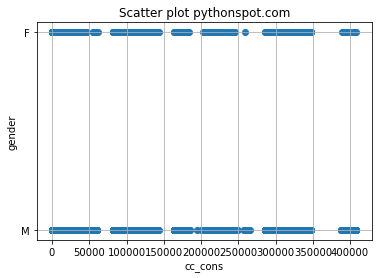

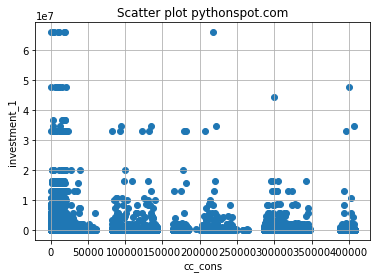

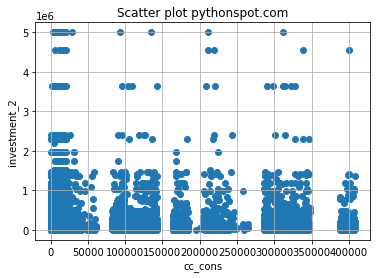

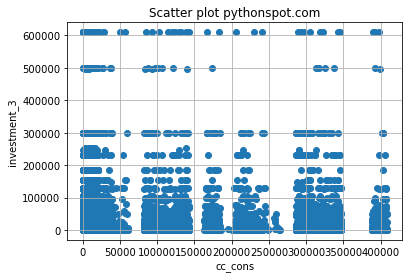

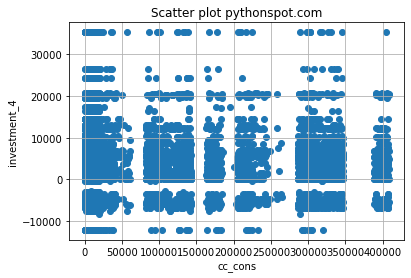

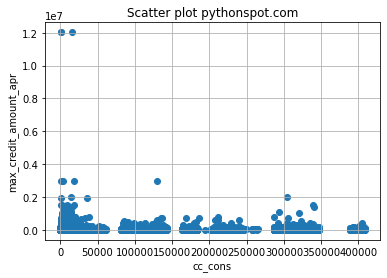

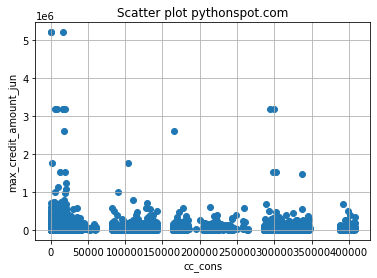

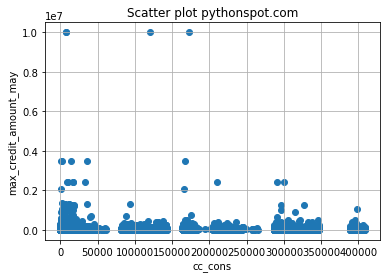

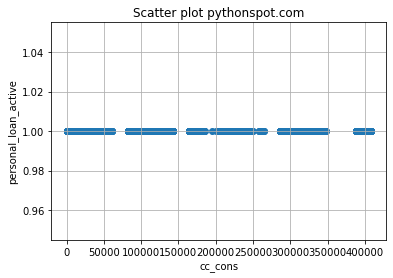

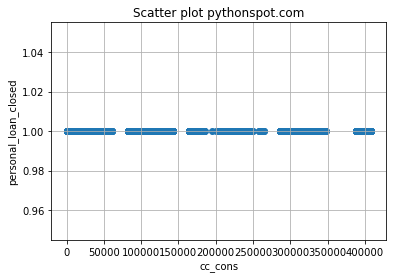

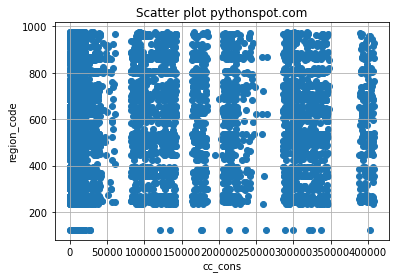

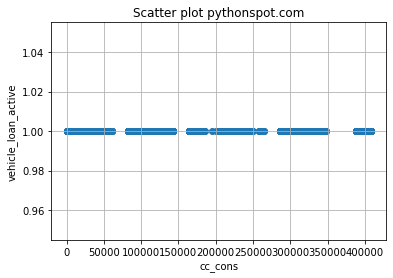

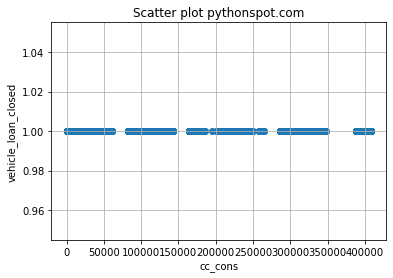

In [22]:
# Checking Bi-Variate Relationship with taget variable, checking relationship of y with every X variable.
for i in credit_spend_existing.columns.difference(['cc_cons',"loan_enq"]):  # loan_enq is categorical in nature
    plt.scatter(credit_spend_existing.cc_cons,credit_spend_existing[i])
    plt.title('Scatter plot pythonspot.com')
    plt.xlabel('cc_cons')
    plt.ylabel(str(i))
    plt.show()  

In [23]:
#import pandas_profiling
#profile_report= pandas_profiling.ProfileReport(credit_spend_existing)
#profile_report.to_file('profileReport.html')

In [24]:
#Insights from Pandas_Profiling
#1. 'ID'has most unique varible,we can drop it
#2. 

In [25]:
credit_spend_existing.head()

,ID,cc_cons,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
0,12554,20014.0,current,M,35,MEDIUM,15.0,1,708.0,0,17.0,24893.00,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26,10,48,14,47,430000,1,1,1.0,1,593.20,1244.14,787.0,6885.0,85919.48,25192.00,24.0,6,25296.0,11527.50,191777.13,2,40,24563.0,30051.32,12761.0,2,65,50836.0,Y,1674.09
1,17645,10173.0,current,M,35,HIGH,15.0,6,123.0,0,14.0,18941.62,966.00,20672.00,287.00,4217.00,885.00,1.0,7,13,3,21,31,127500,1,1,1.0,1,213557.15,172678.56,90525.0,1500.0,12255.75,88693.37,35.0,36,80750.0,92276.57,71162.00,2,78,23948.0,42119.05,76206.0,21,63,23226.0,Y,13043.34
2,7604,16095.0,current,M,55,MEDIUM,24.5,1,802.0,1,3.0,5678.87,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32,102,4,1,80,199999,1,1,1.0,1,165907.57,470000.00,25524.0,3735.0,34193.00,84880.00,72.0,9,38466.0,19343.00,70978.00,2,82,10752.0,58373.25,75283.0,7,1,27036.0,Y,25375.27
3,1590,7707.0,current,F,29,MEDIUM,4.5,6,867.0,1,4.0,30489.50,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1,50,1,1,10,155000,1,1,1.0,1,81872.65,223379.40,48500.0,-4679.0,11558.23,236326.00,43.0,30,52732.0,43867.91,63033.84,23,38,12607.0,69851.51,68708.0,21,83,43037.0,Y,3544.33
4,16556,96408.0,current,M,34,MEDIUM,12.6,4,802.0,1,7.0,7441.40,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47,82,54,16,68,297000,1,1,1.0,1,568.80,385000.00,183999.0,6916.0,17022.81,58897.03,46.0,36,19613.0,153253.71,30286.00,24,50,25213.0,10071.00,80140.0,8,32,32044.0,NaN,12780.44


In [26]:
credit_spend_existing.shape

(15000, 49)

In [27]:
credit_spend_existing.describe()

,ID,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,14999.000000,15000.000000,15000.000000,1.500000e+04,15000.000000,15000.000000,15000.000000,14999.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.0,15000.0,14999.0,15000.0,1.500000e+04,1.500000e+04,14998.000000,15000.000000,1.500000e+04,1.500000e+04,14999.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.500000e+04,1.500000e+04,15000.000000,15000.000000,1.500000e+04,1.499900e+04
mean,10032.077067,55157.729867,47.790600,15.184007,5.510000,598.415467,0.719533,11.049603,17957.391719,8171.098287,1.633705e+04,7703.605203,12129.010832,7097.395321,41.489499,33.490200,41.507000,17.171000,13.979733,30.287267,277005.147400,1.0,1.0,1.0,1.0,6.194140e+05,2.333642e+05,44440.944719,3523.049025,6.823421e+04,8.079761e+04,36.402227,11.291400,5.438954e+04,6.554492e+04,8.356935e+04,11.923133,40.996867,5.718791e+04,7.615987e+04,7.850316e+04,19.946400,44.647867,5.258654e+04,1.576139e+04
std,5760.372343,97670.972252,30.632766,20.312648,2.865783,220.062345,0.449242,5.492379,25187.939958,14773.029481,2.706085e+04,18987.296785,18488.781136,13251.695907,97.435394,49.540999,47.342918,19.359678,17.087203,29.252490,179429.540139,0.0,0.0,0.0,0.0,3.087815e+06,4.073237e+05,88117.933782,7373.355434,1.126786e+05,1.989060e+05,30.701081,12.670785,1.950943e+05,1.016829e+05,1.776300e+05,16.843563,40.537354,2.000194e+05,1.545112e+05,1.482005e+05,27.200165,35.089082,1.282601e+05,1.179191e+05
min,1.000000,0.000000,25.000000,0.500000,1.000000,123.000000,0.000000,2.000000,253.000000,19.350000,1.570000e+02,22.000000,65.000000,62.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.0,1.0,1.0,1.0,3.000000e-01,3.000000e+00,462.000000,-12179.000000,4.010000e+00,6.138000e+01,0.000000,0.000000,1.000000e+00,2.820000e+01,1.061000e+01,0.000000,0.000000,2.500000e-01,5.230000e+00,1.188000e+01,1.000000,0.000000,6.000000e-02,0.000000e+00
25%,5060.500000,6768.000000,33.000000,5.100000,3.000000,424.000000,0.000000,6.000000,4411.027500,1634.000000,3.638000e+03,1643.500000,3004.500000,1358.750000,5.000000,8.000000,10.000000,2.000000,2.000000,4.000000,124000.000000,1.0,1.0,1.0,1.0,6.100000e+03,3.817300e+04,2214.000000,0.000000,2.323043e+04,2.684600e+04,11.000000,2.000000,2.068300e+04,2.100333e+04,2.541027e+04,2.000000,11.000000,2.008300e+04,2.573259e+04,2.492008e+04,4.000000,12.000000,1.903800e+04,1.549350e+03
50%,10054.000000,13364.000000,40.000000,9.900000,6.000000,623.000000,1.000000,11.000000,10288.100000,3996.900000,8.695030e+03,3820.500000,6655.250000,3327.000000,10.000000,23.000000,35.000000,7.000000,5.000000,17.000000,272000.000000,1.0,1.0,1.0,1.0,4.503600e+04,1.110000e+05,13873.000000,2351.000000,4.187560e+04,4.709700e+04,32.000000,5.000000,3.191500e+04,3.823568e+04,4.814000e+04,4.000000,23.000000,3.140300e+04,4.580365e+04,4.590000e+04,7.000000,38.000000,3.042550e+04,3.955280e+03
75%,15015.250000,20105.750000,53.000000,18.000000,8.000000,799.000000,1.000000,16.000000,21405.000000,9339.020000,1.895130e+04,8212.000000,14247.000000,7597.000000,44.000000,43.000000,61.000000,25.000000,21.000000,54.000000,400000.000000,1.0,1.0,1.0,1.0,1.617040e+05,2.450000e+05,48950.000000,6885.000000,7.536829e+04,8.593500e+04,52.

<AxesSubplot:>

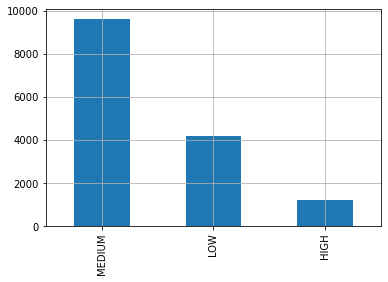

In [28]:
credit_spend_existing.Income.value_counts().plot(kind= 'bar')

##### Here our Y variable is cc_cons that is credit consumtion is a numerical variable, this problem comes in to regression problem

## Data Cleaning

## Drop Variables

In [29]:
credit_spend_existing.drop(["ID"],axis=1, inplace=True) # due to uniqueness of ID variable we drop this variable

C:\Users\Vicky\anaconda31\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [30]:
## The Distribution of Y variable should be normally distributed ( Assumption of linear regression)

C:\Users\Vicky\anaconda31\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


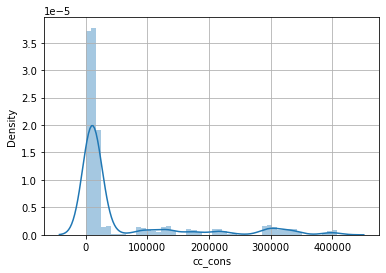

In [31]:
sns.distplot(credit_spend_existing.cc_cons)
plt.show()

C:\Users\Vicky\AppData\Local\Temp/ipykernel_2564/359097541.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_spend_existing['ln_cc_cons']= np.log(credit_spend_existing['cc_cons']+1)
C:\Users\Vicky\anaconda31\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


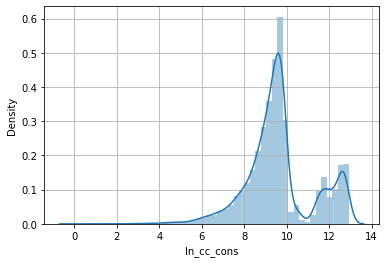

In [32]:
credit_spend_existing['ln_cc_cons']= np.log(credit_spend_existing['cc_cons']+1)
sns.distplot(credit_spend_existing.ln_cc_cons)
plt.show()

In [33]:
credit_spend_existing.columns

Index(['cc_cons', 'account_type', 'gender', 'age', 'Income', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'loan_enq', 'emi_active', 'ln_cc_cons'], dtype='object')

In [34]:
# Creating Categorical List= Containsb categorical variables...

In [35]:
for x in ['account_type','gender', 'Income','loan_enq']:
    credit_spend_existing[x]=credit_spend_existing[x].astype('object')

C:\Users\Vicky\AppData\Local\Temp/ipykernel_2564/2626726355.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_spend_existing[x]=credit_spend_existing[x].astype('object')


# Separate numerical and categorical variable

### To do that you need to apply for loop along with if condition.



In [36]:
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(credit_spend_existing.dtypes) if dict(credit_spend_existing.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(credit_spend_existing.dtypes) if dict(credit_spend_existing.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['cc_cons', 'age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active', 'ln_cc_cons']
['account_type', 'gender', 'Income', 'loan_enq']


In [37]:
#Convert a list in to dataframe 
#Information about numericvariable in custdata_df

credit_spend_existing_num=credit_spend_existing[numeric_var_names]
credit_spend_existing_num

,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,ln_cc_cons
0,20014.0,35,15.0,1,708.0,0,17.0,24893.00,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26,10,48,14,47,430000,1,1,1.0,1,593.200,1244.14,787.0,6885.00000,85919.48,25192.00,24.0,6,25296.0,11527.50,191777.13,2,40,24563.0,30051.32,12761.00,2,65,50836.00,1674.09,9.904237
1,10173.0,35,15.0,6,123.0,0,14.0,18941.62,966.00,20672.00,287.00,4217.00,885.00,1.0,7,13,3,21,31,127500,1,1,1.0,1,213557.150,172678.56,90525.0,1500.00000,12255.75,88693.37,35.0,36,80750.0,92276.57,71162.00,2,78,23948.0,42119.05,76206.00,21,63,23226.00,13043.34,9.227591
2,16095.0,55,24.5,1,802.0,1,3.0,5678.87,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32,102,4,1,80,199999,1,1,1.0,1,165907.570,470000.00,25524.0,3735.00000,34193.00,84880.00,72.0,9,38466.0,19343.00,70978.00,2,82,10752.0,58373.25,75283.00,7,1,27036.00,25375.27,9.686326
3,7707.0,29,4.5,6,867.0,1,4.0,30489.50,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1,50,1,1,10,155000,1,1,1.0,1,81872.650,223379.40,48500.0,-4679.00000,11558.23,236326.00,43.0,30,52732.0,43867.91,63033.84,23,38,12607.0,69851.51,68708.00,21,83,43037.00,3544.33,8.950014
4,96408.0,34,12.6,4,802.0,1,7.0,7441.40,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47,82,54,16,68,297000,1,1,1.0,1,568.800,385000.00,183999.0,6916.00000,17022.81,58897.03,46.0,36,19613.0,153253.71,30286.00,24,50,25213.0,10071.00,80140.00,8,32,32044.00,12780.44,11.476355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,4263.0,53,13.2,9,653.0,1,20.0,10443.76,1218.85,7252.24,3873.00,6633.00,10107.00,3.0,36,3,44,55,29,520000,1,1,1.0,1,186189.000,24000.00,16215.0,977.00000,30608.54,31135.00,79.0,2,27608.0,30501.77,23692.00,1,8,6936.0,487751.19,42625.50,14,8,82851.00,78966.76,8.357963
14996,11019.0,44,2.4,9,535.0,1,2.0,29890.33,6308.00,16025.50,7610.00,2213.08,841.60,1.0,34,4,7,1,2,472000,1,1,1.0,1,24832.000,221000.00,12337.0,-6281.37988,39903.00,23797.00,43.0,2,30512.0,57918.69,50023.00,4,20,202639.0,8666.01,34987.55,11,18,118110.47,4762.10,9.307467
14997,404227.0,37,3.4,9,464.0,1,8.0,4148.98,948.74,19360.26,494.00,44363.91,1801.77,57.0,23,61,24,3,3,44000,1,1,1.0,1,180615.020,253000.00,25000.0,10210.00000,29525.63,95477.27,4.0,1,41085.0,25404.75,35239.00,43,5,44421.0,97896.48,261432.00,4,73,49545.00,2877.33,12.909734
14998,28813.0,220,40.0,10,536.0,1,3.0,115574.00,7191.05,44341.13,34817.20,20679.00,1010.00,7.0,128,44,3,9,1,359000,1,1,1.0,1,3299447.136,393982.10,3975.0,-4664.00000,119370.54,59644.00,3.0,29,19110.0,46086.90,82193.00,3,25,22409.0,22693.92,33025.29,3,80,16130.00,13006.84,10.268617


In [38]:
#Convert a list in to dataframe 
#Information about categorical variable in custdata_df

credit_spend_existing_cat=credit_spend_existing[cat_var_names]
credit_spend_existing_cat.head(5)

,account_type,gender,Income,loan_enq
0,current,M,MEDIUM,Y
1,current,M,HIGH,Y
2,current,M,MEDIUM,Y
3,current,F,MEDIUM,Y
4,current,M,MEDIUM,NaN


## Creating Data audit Report

In [39]:
# Use a general function that returns multiple values
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

num_summary=credit_spend_existing_num.apply(lambda x: var_summary(x)).T

In [40]:
num_summary

,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
cc_cons,15000.0,0.0,8.273659e+08,55157.729867,13364.000000,9.767097e+04,9.539619e+09,0.00,271.990000,1290.85000,2633.600000,6768.000000,13364.000000,20105.750000,219688.700000,3.098520e+05,3.952905e+05,4.083820e+05
age,15000.0,0.0,7.168590e+05,47.790600,40.000000,3.063277e+01,9.383664e+02,25.00,27.000000,28.00000,29.000000,33.000000,40.000000,53.000000,64.000000,6.600000e+01,2.220000e+02,2.230000e+02
Emp_Tenure_Years,15000.0,0.0,2.277601e+05,15.184007,9.900000,2.031265e+01,4.126037e+02,0.50,0.900000,1.70000,2.700000,5.100000,9.900000,18.000000,31.000000,4.000000e+01,1.212000e+02,2.030000e+02
Tenure_with_Bank,15000.0,0.0,8.265000e+04,5.510000,6.000000,2.865783e+00,8.212714e+00,1.00,1.000000,1.00000,2.000000,3.000000,6.000000,8.000000,10.000000,1.000000e+01,1.000000e+01,1.000000e+01
region_code,15000.0,0.0,8.976232e+06,598.415467,623.000000,2.200623e+02,4.842744e+04,123.00,233.000000,249.00000,269.000000,424.000000,623.000000,799.000000,883.000000,9.370000e+02,9.680000e+02,9.740000e+02
NetBanking_Flag,15000.0,0.0,1.079300e+04,0.719533,1.000000,4.492422e-01,2.018186e-01,0.00,0.000000,0.00000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000e+00
Avg_days_between_transaction,14999.0,1.0,1.657330e+05,11.049603,11.000000,5.492379e+00,3.016623e+01,2.00,2.000000,2.00000,3.000000,6.000000,11.000000,16.000000,19.000000,2.000000e+01,2.000000e+01,2.000000e+01
cc_cons_apr,15000.0,0.0,2.693609e+08,17957.391719,10288.100000,2.518794e+04,6.344323e+08,253.00,658.766900,1239.40000,1918.970000,4411.027500,10288.100000,21405.000000,40998.681000,6.015714e+04,1.238253e+05,4.410313e+05
dc_cons_apr,15000.0,0.0,1.225665e+08,8171.098287,3996.900000,1.477303e+04,2.182424e+08,19.35,153.140000,376.00000,658.500000,1634.000000,3996.900000,9339.020000,18435.367000,2.783500e+04,6.480400e+04,2.292550e+05
cc_cons_may,15000.0,0.0,2.450558e+08,16337.054662,8695.030000,2.706085e+04,7.322896e+08,157.00,508.980000,1043.04000,1677.000000,3638.000000,8695.030000,18951.300000,36299.360000,5.488771e+04,1.264680e+05,1.117246e+06


In [41]:
def cat_summary(x):
    return pd.Series([x.count(),x.isnull().sum(),x.value_counts(),x.unique()],
                    index=['N','NMISS','ColumnNames','UniqueValues'])

In [42]:
cat_summary=credit_spend_existing.apply(lambda x:cat_summary(x)).T

In [43]:
cat_summary

,N,NMISS,ColumnNames,UniqueValues
cc_cons,15000,0,6035.0 5 13260.0 5 6682.0 5 6203...,"[20014.0, 10173.0, 16095.0, 7707.0, 96408.0, 1..."
account_type,15000,0,current 12727 saving 2273 Name: accoun...,"[current, saving]"
gender,15000,0,"M 12945 F 2055 Name: gender, dtype: int64","[M, F]"
age,15000,0,33 1290 47 921 32 809 53 76...,"[35, 55, 29, 34, 27, 32, 28, 67, 37, 46, 38, 6..."
Income,15000,0,MEDIUM 9612 LOW 4188 HIGH 1200 N...,"[MEDIUM, HIGH, LOW]"
Emp_Tenure_Years,15000,0,6.0 293 12.0 287 7.2 252 10.8 ...,"[15.0, 24.5, 4.5, 12.600000000000001, 4.9, 4.8..."
Tenure_with_Bank,15000,0,7 1562 6 1534 10 1527 4 1519 2 ...,"[1, 6, 4, 3, 5, 10, 7, 2, 9, 8]"
region_code,15000,0,249.0 395 867.0 280 683.0 271 355.0 ...,"[708.0, 123.0, 802.0, 867.0, 958.0, 805.0, 448..."
NetBanking_Flag,15000,0,"1 10793 0 4207 Name: NetBanking_Flag, d...","[0, 1]"
Avg_days_between_transaction,14999,1,19.0 849 16.0 830 6.0 824 14.0 81...,"[17.0, 14.0, 3.0, 4.0, 7.0, 11.0, 18.0, 16.0, ..."


## Handling Outliers

## There are some extreame high or extream low value which need to rectify so that it will not have impact on our model

In [44]:
#Handling Outliers for numerical data - Through function
credit_spend_existing_num=  credit_spend_existing_num.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

In [45]:
credit_spend_existing_num

,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,ln_cc_cons
0,20014.00,35.0,15.0,1,708.0,0,17.0,24893.00,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26.0,10.0,48.0,14.0,47,430000.0,1,1,1.0,1,593.200,1244.14,787.0,6885.00000,85919.48,25192.0000,24.0,6.0,25296.0,11527.50,191777.13,2.0,40.0,24563.0,30051.32,12761.00,2,65.0,50836.00,1674.09,9.904237
1,10173.00,35.0,15.0,6,233.0,0,14.0,18941.62,966.00,20672.00,287.00,4217.00,885.00,1.0,7.0,13.0,3.0,21.0,31,127500.0,1,1,1.0,1,213557.150,172678.56,90525.0,1500.00000,12255.75,88693.3700,35.0,36.0,80750.0,92276.57,71162.00,2.0,78.0,23948.0,42119.05,76206.00,21,63.0,23226.00,13043.34,9.227591
2,16095.00,55.0,24.5,1,802.0,1,3.0,5678.87,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32.0,102.0,4.0,1.0,80,199999.0,1,1,1.0,1,165907.570,470000.00,25524.0,3735.00000,34193.00,84880.0000,72.0,9.0,38466.0,19343.00,70978.00,2.0,82.0,10752.0,58373.25,75283.00,7,1.0,27036.00,25375.27,9.686326
3,7707.00,29.0,4.5,6,867.0,1,4.0,30489.50,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1.0,50.0,1.0,1.0,10,155000.0,1,1,1.0,1,81872.650,223379.40,48500.0,-4679.00000,11558.23,236326.0000,43.0,30.0,52732.0,43867.91,63033.84,23.0,38.0,12607.0,69851.51,68708.00,21,83.0,43037.00,3544.33,8.950014
4,96408.00,34.0,12.6,4,802.0,1,7.0,7441.40,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47.0,82.0,54.0,16.0,68,297000.0,1,1,1.0,1,568.800,385000.00,183999.0,6916.00000,17022.81,58897.0300,46.0,36.0,19613.0,153253.71,30286.00,24.0,50.0,25213.0,10071.00,80140.00,8,32.0,32044.00,12780.44,11.476355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,4263.00,53.0,13.2,9,653.0,1,20.0,10443.76,1218.85,7252.24,3873.00,6633.00,10107.00,3.0,36.0,3.0,44.0,55.0,29,520000.0,1,1,1.0,1,186189.000,24000.00,16215.0,977.00000,30608.54,31135.0000,79.0,2.0,27608.0,30501.77,23692.00,1.0,8.0,6936.0,487751.19,42625.50,14,8.0,82851.00,78966.76,8.357963
14996,11019.00,44.0,2.4,9,535.0,1,2.0,29890.33,6308.00,16025.50,7610.00,2213.08,841.60,1.0,34.0,4.0,7.0,1.0,2,472000.0,1,1,1.0,1,24832.000,221000.00,12337.0,-6281.37988,39903.00,23797.0000,43.0,2.0,30512.0,57918.69,50023.00,4.0,20.0,202639.0,8666.01,34987.55,11,18.0,118110.47,4762.10,9.307467
14997,395290.55,37.0,3.4,9,464.0,1,8.0,4148.98,948.74,19360.26,494.00,44363.91,1801.77,57.0,23.0,61.0,24.0,3.0,3,44000.0,1,1,1.0,1,180615.020,253000.00,25000.0,10210.00000,29525.63,95477.2700,4.0,1.0,41085.0,25404.75,35239.00,43.0,5.0,44421.0,97896.48,261432.00,4,73.0,49545.00,2877.33,12.887379
14998,28813.00,220.0,40.0,10,536.0,1,3.0,115574.00,7191.05,44341.13,34817.20,20679.00,1010.00,7.0,128.0,44.0,3.0,9.0,1,359000.0,1,1,1.0,1,3299447.136,393982.10,3975.0,-4664.00000,119370.54,59644.0000,3.0,29.0,19110.0,46086.90,82193.00,3.0,25.0,22409.0,22693.92,33025.29,3,80.0,16130.00,13006.84,10.268617


In [46]:
credit_spend_existing_num.describe()

,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,ln_cc_cons
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,14999.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,14999.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.0,15000.0,14999.0,15000.0,1.500000e+04,1.500000e+04,14998.000000,15000.000000,15000.000000,15000.000000,14999.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,14999.000000,15000.000000
mean,55091.027333,47.797333,14.733960,5.510000,599.090467,0.719533,11.049603,17400.638053,7666.626111,15707.246484,7140.883809,11630.523379,6765.903731,41.489499,31.188267,39.814867,17.025667,13.929867,30.287267,276240.014067,1.0,1.0,1.0,1.0,4.983192e+05,2.204552e+05,44441.147146,3490.934025,64681.912692,74527.772691,36.408561,11.232400,48280.392740,62587.697771,77191.895444,11.921733,41.000867,49779.206931,70746.220450,72867.690725,19.946400,44.615467,48010.760279,10238.247058,9.654838
std,97429.489575,30.580459,17.031901,2.865783,218.662770,0.449242,5.492379,21123.224620,10504.034191,20505.046326,10142.227951,14493.843750,10448.125288,97.435394,30.413562,32.333861,18.943020,16.933736,29.252490,176760.829233,0.0,0.0,0.0,0.0,1.753966e+06,3.141893e+05,88117.832808,7029.362334,75087.828632,89002.653075,30.693672,12.474613,54220.072152,73555.874626,88008.468243,16.838693,40.533357,56631.874128,79925.279803,86002.394017,27.200165,35.011550,57778.482365,21873.991759,1.579222
min,271.990000,27.000000,0.900000,1.000000,233.000000,0.000000,2.000000,658.766900,153.140000,508.980000,156.951000,334.000000,188.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16000.000000,1.0,1.0,1.0,1.0,1.219000e+01,6.000000e+00,505.000000,-7652.000000,199.346300,486.000000,1.000000,0.000000,468.950000,1083.691400,297.000000,0.000000,1.000000,129.988900,1077.000000,292.960000,1.000000,0.000000,163.000000,26.683200,5.609435
25%,6768.000000,33.000000,5.100000,3.000000,424.000000,0.000000,6.000000,4411.027500,1634.000000,3638.000000,1643.500000,3004.500000,1358.750000,5.000000,8.000000,10.000000,2.000000,2.000000,4.000000,124000.000000,1.0,1.0,1.0,1.0,6.100000e+03,3.817300e+04,2214.000000,0.000000,23230.430000,26846.000000,11.000000,2.000000,20683.000000,21003.330000,25410.270000,2.000000,11.000000,20083.000000,25732.592500,24920.080000,4.000000,12.000000,19038.000000,1549.350000,8.820109
50%,13364.000000,40.000000,9.900000,6.000000,623.000000,1.000000,11.000000,10288.100000,3996.900000,8695.030000,3820.500000,6655.250000,3327.000000,10.000000,23.000000,35.000000,7.000000,5.000000,17.000000,272000.000000,1.0,1.0,1.0,1.0,4.503600e+04,1.110000e+05,13873.000000,2351.000000,41875.600000,47097.000000,32.000000,5.000000,31915.000000,38235.680000,48140.000000,4.000000,23.000000,31403.000000,45803.650000,45900.000000,7.000000,38.000000,30425.500000,3955.280000,9.500395
75%,20105.750000,53.000000,18.000000,8.000000,799.000000,1.000000,16.000000,21405.000000,9339.020000,18951.300000,8212.000000,14247.000000,7597.000000,44.000000,43.000000,61.000000,25.000000,21.000000,54.000000,400000.000000,1.0,1.0,1.0,1.0,1.617040e+05,2.450000e+05,48950.000000,6885.000000,75368.295000,85935.000000,52.000000,19.000000,52559.000000,74400

## Handling Missing Values
#### As we can see in the above audit report some data is missing in numerical data set and some are missing in categorical. We will treat numerical missing data with mean() and categorical data with mode()

In [47]:
#for categorical and continuous variables
credit_spend_existing_num = credit_spend_existing_num.apply(missing_imputation)
credit_spend_existing_num

,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,ln_cc_cons
0,20014.00,35.0,15.0,1,708.0,0,17.0,24893.00,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26.0,10.0,48.0,14.0,47,430000.0,1,1,1.0,1,593.200,1244.14,787.0,6885.00000,85919.48,25192.0000,24.0,6.0,25296.0,11527.50,191777.13,2.0,40.0,24563.0,30051.32,12761.00,2,65.0,50836.00,1674.09,9.904237
1,10173.00,35.0,15.0,6,233.0,0,14.0,18941.62,966.00,20672.00,287.00,4217.00,885.00,1.0,7.0,13.0,3.0,21.0,31,127500.0,1,1,1.0,1,213557.150,172678.56,90525.0,1500.00000,12255.75,88693.3700,35.0,36.0,80750.0,92276.57,71162.00,2.0,78.0,23948.0,42119.05,76206.00,21,63.0,23226.00,13043.34,9.227591
2,16095.00,55.0,24.5,1,802.0,1,3.0,5678.87,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32.0,102.0,4.0,1.0,80,199999.0,1,1,1.0,1,165907.570,470000.00,25524.0,3735.00000,34193.00,84880.0000,72.0,9.0,38466.0,19343.00,70978.00,2.0,82.0,10752.0,58373.25,75283.00,7,1.0,27036.00,25375.27,9.686326
3,7707.00,29.0,4.5,6,867.0,1,4.0,30489.50,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1.0,50.0,1.0,1.0,10,155000.0,1,1,1.0,1,81872.650,223379.40,48500.0,-4679.00000,11558.23,236326.0000,43.0,30.0,52732.0,43867.91,63033.84,23.0,38.0,12607.0,69851.51,68708.00,21,83.0,43037.00,3544.33,8.950014
4,96408.00,34.0,12.6,4,802.0,1,7.0,7441.40,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47.0,82.0,54.0,16.0,68,297000.0,1,1,1.0,1,568.800,385000.00,183999.0,6916.00000,17022.81,58897.0300,46.0,36.0,19613.0,153253.71,30286.00,24.0,50.0,25213.0,10071.00,80140.00,8,32.0,32044.00,12780.44,11.476355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,4263.00,53.0,13.2,9,653.0,1,20.0,10443.76,1218.85,7252.24,3873.00,6633.00,10107.00,3.0,36.0,3.0,44.0,55.0,29,520000.0,1,1,1.0,1,186189.000,24000.00,16215.0,977.00000,30608.54,31135.0000,79.0,2.0,27608.0,30501.77,23692.00,1.0,8.0,6936.0,487751.19,42625.50,14,8.0,82851.00,78966.76,8.357963
14996,11019.00,44.0,2.4,9,535.0,1,2.0,29890.33,6308.00,16025.50,7610.00,2213.08,841.60,1.0,34.0,4.0,7.0,1.0,2,472000.0,1,1,1.0,1,24832.000,221000.00,12337.0,-6281.37988,39903.00,23797.0000,43.0,2.0,30512.0,57918.69,50023.00,4.0,20.0,202639.0,8666.01,34987.55,11,18.0,118110.47,4762.10,9.307467
14997,395290.55,37.0,3.4,9,464.0,1,8.0,4148.98,948.74,19360.26,494.00,44363.91,1801.77,57.0,23.0,61.0,24.0,3.0,3,44000.0,1,1,1.0,1,180615.020,253000.00,25000.0,10210.00000,29525.63,95477.2700,4.0,1.0,41085.0,25404.75,35239.00,43.0,5.0,44421.0,97896.48,261432.00,4,73.0,49545.00,2877.33,12.887379
14998,28813.00,220.0,40.0,10,536.0,1,3.0,115574.00,7191.05,44341.13,34817.20,20679.00,1010.00,7.0,128.0,44.0,3.0,9.0,1,359000.0,1,1,1.0,1,3299447.136,393982.10,3975.0,-4664.00000,119370.54,59644.0000,3.0,29.0,19110.0,46086.90,82193.00,3.0,25.0,22409.0,22693.92,33025.29,3,80.0,16130.00,13006.84,10.268617


In [48]:
credit_spend_existing_cat = credit_spend_existing_cat.apply(missing_imputation)
credit_spend_existing_cat

,account_type,gender,Income,loan_enq
0,current,M,MEDIUM,Y
1,current,M,HIGH,Y
2,current,M,MEDIUM,Y
3,current,F,MEDIUM,Y
4,current,M,MEDIUM,Y
...,...,...,...,...
14995,current,F,LOW,Y
14996,current,M,MEDIUM,Y
14997,current,M,MEDIUM,Y
14998,current,M,MEDIUM,Y


## Again check missing values has been treated or not

In [49]:
# Find the total number of missing values in the numerical data i.e custdata_df_num
print ("\nMissing values in numerical data :  ", credit_spend_existing_num.isnull().sum().values.sum())
print ("\nMissing values in categorical data :  ", credit_spend_existing_cat.isnull().sum().values.sum())


Missing values in numerical data :   0

Missing values in categorical data :   0


## Dummy creation for categorical data¶


In [50]:
# We need to create a function for dummy creation
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname)
    col_dummies.drop(col_dummies.columns[0], axis = 1, inplace = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True)
    return df

In [51]:
credit_spend_existing_cat=credit_spend_existing.select_dtypes(include=['object'])
cat_varlist=list(credit_spend_existing_cat.columns)

In [52]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    credit_spend_existing_cat[c_feature]=credit_spend_existing_cat[c_feature].astype('category')
    credit_spend_existing_cat=create_dummies(credit_spend_existing_cat,c_feature)

C:\Users\Vicky\AppData\Local\Temp/ipykernel_2564/2725018023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_spend_existing_cat[c_feature]=credit_spend_existing_cat[c_feature].astype('category')


In [53]:
credit_spend_existing_cat.sample(5)

,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
3632,0,1,0,1
2248,0,1,0,1
273,0,1,0,1
2031,0,1,1,0
11182,0,1,0,0


## Merge Numerical and categorical data

### Now we have nice simple clean data for numerical and categorical both data frame, so now we can merge both data set

In [54]:
credit_spend_existing_fin = pd.concat([credit_spend_existing_num, credit_spend_existing_cat], axis=1)


In [55]:
credit_spend_existing_fin.head()

,cc_cons,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,ln_cc_cons,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
0,20014.0,35.0,15.0,1,708.0,0,17.0,24893.00,378.00,10288.00,29664.00,16291.40,11432.00,2.0,26.0,10.0,48.0,14.0,47,430000.0,1,1,1.0,1,593.20,1244.14,787.0,6885.0,85919.48,25192.00,24.0,6.0,25296.0,11527.50,191777.13,2.0,40.0,24563.0,30051.32,12761.0,2,65.0,50836.0,1674.09,9.904237,0,1,0,1
1,10173.0,35.0,15.0,6,233.0,0,14.0,18941.62,966.00,20672.00,287.00,4217.00,885.00,1.0,7.0,13.0,3.0,21.0,31,127500.0,1,1,1.0,1,213557.15,172678.56,90525.0,1500.0,12255.75,88693.37,35.0,36.0,80750.0,92276.57,71162.00,2.0,78.0,23948.0,42119.05,76206.0,21,63.0,23226.0,13043.34,9.227591,0,1,0,0
2,16095.0,55.0,24.5,1,802.0,1,3.0,5678.87,2724.00,1964.50,3933.11,23956.25,5168.00,43.0,32.0,102.0,4.0,1.0,80,199999.0,1,1,1.0,1,165907.57,470000.00,25524.0,3735.0,34193.00,84880.00,72.0,9.0,38466.0,19343.00,70978.00,2.0,82.0,10752.0,58373.25,75283.0,7,1.0,27036.0,25375.27,9.686326,0,1,0,1
3,7707.0,29.0,4.5,6,867.0,1,4.0,30489.50,1236.00,12609.88,9138.14,17521.00,13650.30,53.0,1.0,50.0,1.0,1.0,10,155000.0,1,1,1.0,1,81872.65,223379.40,48500.0,-4679.0,11558.23,236326.00,43.0,30.0,52732.0,43867.91,63033.84,23.0,38.0,12607.0,69851.51,68708.0,21,83.0,43037.0,3544.33,8.950014,0,0,0,1
4,96408.0,34.0,12.6,4,802.0,1,7.0,7441.40,6906.04,4364.00,1939.00,2121.00,6829.18,67.0,47.0,82.0,54.0,16.0,68,297000.0,1,1,1.0,1,568.80,385000.00,183999.0,6916.0,17022.81,58897.03,46.0,36.0,19613.0,153253.71,30286.00,24.0,50.0,25213.0,10071.00,80140.0,8,32.0,32044.0,12780.44,11.476355,0,1,0,1


In [56]:
#credit_spend_existing_fin.drop('ln_cc_cons', axis= 1, inplace=True)
#credit_spend_existing_fin.drop(['cc_cons'],axis=1, inplace=True)

In [57]:
credit_spend_existing_fin.shape

(15000, 49)

## Explore data and check the variable distribution for linear regression modelling


C:\Users\Vicky\anaconda31\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cc_cons', ylabel='Density'>

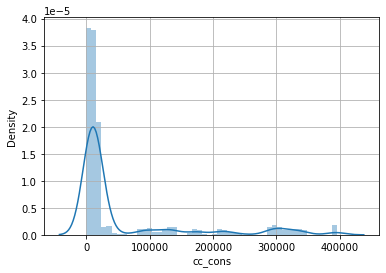

In [58]:
# For Linear regressin y(cc_cons) should follow normal distribution
import seaborn as sns
sns.distplot(credit_spend_existing_fin.cc_cons)

## Now as you can see distribution is right skewed so we need to take log and then plot the graph.

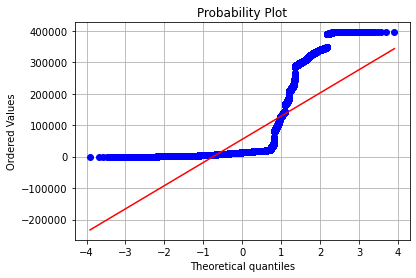

In [59]:
from scipy import stats  # Q-Q plot residual plot
import pylab

stats.probplot(credit_spend_existing_fin.cc_cons, dist="norm", plot=pylab )
pylab.show()

#### As we can see above graph our data is not distributed normally perfectly as discussed previously so we will use boxcox techniue to make it perfect normal

In [60]:
from scipy import stats

# transform training data & save lambda value
credit_spend_existing_fin['bc_cc_cons'],fitted_lambda = stats.boxcox(credit_spend_existing_fin['cc_cons']+1)

C:\Users\Vicky\anaconda31\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='bc_cc_cons', ylabel='Density'>

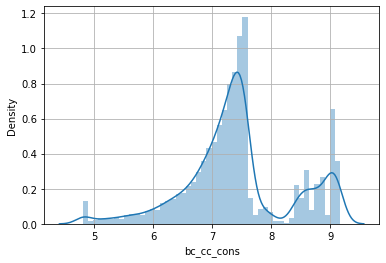

In [61]:
sns.distplot(credit_spend_existing_fin.bc_cc_cons)

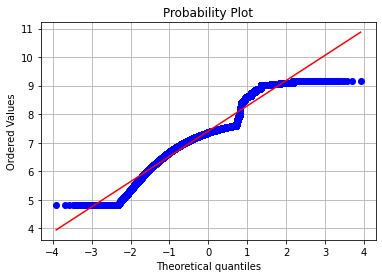

In [62]:
stats.probplot(credit_spend_existing_fin.bc_cc_cons, dist="norm", plot=pylab )
pylab.show()

In [63]:
#Drop the y variables(cc_cons) from dataframe because we are looking correlation between all x variables

#credit_spend_existing_fin.drop(['cc_cons'],axis=1,inplace=True)

In [64]:
credit_spend_existing_fin.drop(['bc_cc_cons','cc_cons'], axis=1, inplace=True)

In [65]:
# We can find out the coreltion with y variable using .corrwith to see co relation.
#corr_y = credit_spend_existing_fin.corrwith(credit_spend_existing_fin.ln_cc_cons)

In [66]:
#corr_y.to_csv('corr_y.csv')

In [67]:
credit_spend_existing_fin.columns

Index(['age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active', 'ln_cc_cons', 'account_type_saving', 'gender_M', 'Income_LOW', 'Income_MEDIUM'], dtype='object')

In [68]:
#Checking Multicolinearity using VIF

In [69]:
lst_vars = ['age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 
            'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 
            'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 
            'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active',
            'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3',
            'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 
            'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may',
            'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 
            'max_credit_amount_jun', 'emi_active', 'ln_cc_cons', 'account_type_saving', 'gender_M', 'Income_LOW',
            'Income_MEDIUM']

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [71]:
X = credit_spend_existing_fin[credit_spend_existing_fin[lst_vars].columns.difference(['ln_cc_cons'])]

In [72]:
vif_values = pd.concat([pd.Series(X.columns), pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])])],axis=1)
vif_values.columns = ['variable', 'vif']
vif_values.sort_values(by='vif', ascending=False)

C:\Users\Vicky\anaconda31\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


,variable,vif
3,Income_MEDIUM,3.243854
2,Income_LOW,3.243605
7,age,2.999627
1,Emp_Tenure_Years,2.998040
11,cc_cons_may,1.004122
31,debit_count_jun,1.004103
23,dc_cons_may,1.003658
32,debit_count_may,1.003634
26,dc_count_may,1.003573
5,Tenure_with_Bank,1.003478


In [73]:
# As VIF values are less than 5 for all X variables, so we will not dropping any variable from the X list

In [74]:
feature_columns=credit_spend_existing_fin.columns.difference(['ln_cc_cons'])

In [75]:
feature_columns

Index(['Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income_LOW', 'Income_MEDIUM', 'NetBanking_Flag', 'Tenure_with_Bank', 'account_type_saving', 'age', 'card_lim', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr', 'cc_count_jun', 'cc_count_may', 'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may', 'credit_count_apr', 'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr', 'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may', 'debit_count_apr', 'debit_count_jun', 'debit_count_may', 'emi_active', 'gender_M', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun', 'max_credit_amount_may', 'personal_loan_active', 'personal_loan_closed', 'region_code', 'vehicle_loan_active', 'vehicle_loan_closed'], dtype='object')

In [76]:
## Divide data into train and test data

In [77]:
#Splitting the data in all x variable and y variable.
from sklearn.model_selection import train_test_split

train_x,test_x,train_y,test_y=train_test_split(credit_spend_existing_fin[feature_columns],
                                              credit_spend_existing_fin['ln_cc_cons'],
                                              test_size=0.2,
                                              random_state=132)

In [78]:
print (len(train_x))
print (len(test_x))
print (len(train_y))
print (len(test_y))

12000
3000
12000
3000


## Random Forest Regression Modelling

In [79]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [80]:
param_grid={'n_estimators':np.arange(5,25)}

tree=GridSearchCV(RandomForestRegressor(oob_score=False,warm_start=True),param_grid,cv=2)
tree.fit(train_x,train_y)  

GridSearchCV(cv=2, estimator=RandomForestRegressor(warm_start=True),
             param_grid={'n_estimators': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24])})

In [85]:
tree.best_params_ 

{'n_estimators': 45}

In [86]:
radm_reg = RandomForestRegressor(oob_score=False,n_estimators=45,max_depth=None)
radm_reg.fit( train_x, train_y)

RandomForestRegressor(n_estimators=45)

##### Prediction task over the test data that is test_x

In [226]:
# Use the predict method on the test data
#pred_y = radm_reg.predict(test_x)

In [98]:
train_pred = np.exp(radm_reg.predict(train_x))
train_actuals = np.exp(train_y)

In [99]:
print('Train_MAPE:', np.mean(np.abs(train_actuals-train_pred)/train_actuals))

Train_MAPE: 0.5076720394520658


In [105]:
test_pred = np.exp(radm_reg.predict(test_x))
test_actuals = np.exp(test_y)

In [106]:
print('Test_MAPE:', np.mean(np.abs(test_actuals-test_pred)/test_actuals))

Test_MAPE: 2.950006413410172


In [108]:
df = pd.DataFrame({'Real Values':test_actuals, 'Predicted Values':test_pred})
df

,Real Values,Predicted Values
2429,18534.0,20067.159862
12906,18659.0,18595.081654
4969,13720.0,20277.113848
6326,211521.0,18178.380985
1662,5534.0,16365.983181
...,...,...
9260,239823.0,13525.233739
8730,12838.0,14508.950908
9991,83164.0,19915.714507
4959,15573.0,18356.081932


In [218]:
errors = abs((pred_y - test_y)/test_y)
print('Mean Absolute Percentage Error:', round(np.mean(errors), 5)) 


Mean Absolute Percentage Error: 12.96327


In [ ]:
# RMSPE on train datasets

In [ ]:
rmspe = np.sqrt(np.mean(np.square(((test_actual - test_pred) / test_actual)), axis=0))
print('Root Mean Squared Percentage Error (RMSPE) for test::', rmspe)

In [ ]:
# RMSPE on test datasets

In [219]:
rmspe = np.sqrt(np.mean(np.square(((train_actual - train_pred) / train_actual)), axis=0))
print('Root Mean Squared Percentage Error (RMSPE) for train ::', rmspe)

Root Mean Squared Percentage Error (RMSPE):: 39.71649464930267


In [220]:
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(test_y, pred_y))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(test_y, pred_y))
print('Root Mean Squared Error (RMSE):', metrics.mean_squared_error(test_y, pred_y, squared=False))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(test_y, pred_y))
print('Explained Variance Score:', metrics.explained_variance_score(test_y, pred_y))
print('Max Error:', metrics.max_error(test_y, pred_y))
print('Mean Squared Log Error:', metrics.mean_squared_log_error(test_y, pred_y))
print('Median Absolute Error:', metrics.median_absolute_error(test_y, pred_y))
print('R^2:', metrics.r2_score(test_y, pred_y))
print('Mean Poisson Deviance:', metrics.mean_poisson_deviance(test_y, pred_y))
print('Mean Gamma Deviance:', metrics.mean_gamma_deviance(test_y, pred_y))

Mean Absolute Error (MAE): 74872.19290101448
Mean Squared Error (MSE): 10097281404.018013
Root Mean Squared Error (RMSE): 100485.22978039118
Mean Absolute Percentage Error (MAPE): 12.963266730053325
Explained Variance Score: -0.09778370944708925
Max Error: 373491.37608695653
Mean Squared Log Error: 4.494737254980677
Median Absolute Error: 56433.33804347826
R^2: -0.10812014547864934
Mean Poisson Deviance: 127638.20728394786
Mean Gamma Deviance: 2.8306217483568594


In [221]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)


In [222]:
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 98.04 %.


In [149]:
## After building model we will apply our new model on new datasets that is credit_spend_new 

# using XGboost Regression

In [150]:
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
#from yellowbrick.regressor import residuals_plot
#from yellowbrick.regressor import prediction_error

In [198]:
# Instantiate an XGBoost object with hyperparameters
xgb_reg = xgb.XGBRegressor(max_depth=3, n_estimators=10, n_jobs=2,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05)

In [199]:
# Train the model with train data sets
xgb_reg.fit(train_x,train_y)

[13:14:40] WARNING: ..\src\learner.cc:573: 
Parameters: { "objectvie" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=2000, n_jobs=2, num_parallel_tree=1,
             objectvie='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [200]:
y_pred = xgb_reg.predict(test_x) # Predictions
y_true = test_y # True values

C:\Users\Vicky\anaconda31\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [201]:
MSE = mse(y_true, y_pred)
RMSE = np.sqrt(MSE)

In [202]:
R_squared = r2_score(y_true, y_pred)

In [203]:
print("\nRMSE: ", np.round(RMSE, 2))
print()
print("R-Squared: ", np.round(R_squared, 2))


RMSE:  99159.36

R-Squared:  -0.08


In [127]:
# Making the Prediction Error Plot
#print("\nPrediction Error Plot")
#print(prediction_error(xgb_reg, X_train, y_train, X_test, y_test))

In [128]:
# Making the Residuals Plot
#print("\nResiduals Plot")
#print(residuals_plot(xgb_reg, X_train, y_train, X_test, y_test))

## TEST ON NEW DATASETS "CREDIT_SPEND_NEW"
### Firstly for testing the model on new datasets, we have to do some data preprocessing steps as did earlier for the modelling purpose.

In [279]:
credit_spend_new.head()


,ID,cc_cons,account_type,gender,age,Income,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,loan_enq,emi_active
15000,17591,NaN,current,M,37,MEDIUM,11.9,4,575.0,1,16.0,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,Y,1170.49
15001,13541,NaN,current,M,33,MEDIUM,7.8,6,394.0,0,19.0,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,Y,16447.45
15002,13431,NaN,current,M,53,LOW,33.0,10,324.0,1,15.0,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,Y,2622.28
15003,8687,NaN,current,M,33,MEDIUM,7.8,5,370.0,1,7.0,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,Y,340.79
15004,14727,NaN,current,M,62,LOW,12.6,9,505.0,1,3.0,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,Y,2812.20


In [280]:
credit_spend_new.drop(['cc_cons','ID'],axis=1, inplace= True)

C:\Users\Vicky\anaconda31\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [281]:
# Creating Categorical List= Containsb categorical variables...

In [282]:
for x in ['account_type','gender', 'Income','loan_enq']:
    credit_spend_new[x]=credit_spend_new[x].astype('object')

C:\Users\Vicky\AppData\Local\Temp/ipykernel_5324/3255829753.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  credit_spend_new[x]=credit_spend_new[x].astype('object')


# Separate numerical and categorical variable for new datasets

In [283]:
### To do that you need to apply for loop along with if condition.

In [284]:
# Find numerical variable in Data frame.
# This will return a list
numeric_var_names = [key for key in dict(credit_spend_new.dtypes) if dict(credit_spend_new.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]

# Find Categorical variable in Data frame
cat_var_names = [key for key in dict(credit_spend_new.dtypes) if dict(credit_spend_new.dtypes)[key] in ['object']]

#Print the data frame
print( numeric_var_names)
print(cat_var_names)

['age', 'Emp_Tenure_Years', 'Tenure_with_Bank', 'region_code', 'NetBanking_Flag', 'Avg_days_between_transaction', 'cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may', 'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may', 'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun', 'card_lim', 'personal_loan_active', 'vehicle_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'investment_1', 'investment_2', 'investment_3', 'investment_4', 'debit_amount_apr', 'credit_amount_apr', 'debit_count_apr', 'credit_count_apr', 'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may', 'credit_count_may', 'debit_count_may', 'max_credit_amount_may', 'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun', 'debit_count_jun', 'max_credit_amount_jun', 'emi_active']
['account_type', 'gender', 'Income', 'loan_enq']


In [285]:
#Convert a list in to dataframe 
#Information about numericvariable in credit_spend_new_num

credit_spend_new_num=credit_spend_new[numeric_var_names]
credit_spend_new_num.head(5)

,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
15000,37,11.9,4,575.0,1,16.0,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,56,6,125000,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36,24485.0,23512.67,41755.0,24,20,9750.0,30527.88,31271.00,3,12,25945.92,1170.49
15001,33,7.8,6,394.0,0,19.0,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,38,31,59000,1,1,1.0,1,101891.25,470000.00,891.0,35346.00000,32247.25,21946.00,42.0,5,3375.0,15049.44,130299.0,43,40,16967.0,14342.83,16582.00,6,39,12214.00,16447.45
15002,53,33.0,10,324.0,1,15.0,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30,5,24,27,2,49999,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6,14950.0,133659.00,40422.0,42,35,36398.0,32503.16,33539.54,5,9,13215.00,2622.28
15003,33,7.8,5,370.0,1,7.0,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,1,11,520000,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1,235844.0,99686.03,48148.0,3,5,97825.0,93572.42,109429.75,21,0,72317.00,340.79
15004,62,12.6,9,505.0,1,3.0,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,25,1,152000,1,1,1.0,1,12850544.36,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1,14495.0,190374.25,25926.0,70,75,27936.0,19011.50,41401.00,6,35,42344.00,2812.20


In [286]:
credit_spend_new_cat=credit_spend_new[cat_var_names]
credit_spend_new_cat.head(5)

,account_type,gender,Income,loan_enq
15000,current,M,MEDIUM,Y
15001,current,M,MEDIUM,Y
15002,current,M,LOW,Y
15003,current,M,MEDIUM,Y
15004,current,M,LOW,Y


# Handling Outliers

In [287]:
#Handling Outliers for numerical data - Through function
credit_spend_new_num=  credit_spend_new_num.apply(lambda x: x.clip(lower = x.quantile(0.01), upper = x.quantile(0.99)))

# Handling Missing Values

In [288]:
#for categorical and continuous variables
credit_spend_new_num = credit_spend_new_num.apply(missing_imputation)
credit_spend_new_num

,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active
15000,37.0,11.9,4,575.0,1,16.000000,2795.450,1290.00,6141.05,676.50,9146.10,15479.00,4.0,10.0,4.0,47.0,56.0,6,125000.0,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36.0,24485.0,23512.67,41755.00,24.0,20.0,9750.0,30527.88,31271.00,3,12.0,25945.92,1170.49
15001,33.0,7.8,6,394.0,0,19.000000,29405.130,1640.00,1670.00,2463.92,10947.50,956.00,3.0,10.0,4.0,50.0,38.0,31,59000.0,1,1,1.0,1,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5.0,3375.0,15049.44,130299.00,43.0,40.0,16967.0,14342.83,16582.00,6,39.0,12214.00,16447.45
15002,53.0,33.0,10,324.0,1,15.000000,5985.200,6189.00,2696.09,766.00,716.00,4133.22,7.0,30.0,5.0,24.0,27.0,2,49999.0,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6.0,14950.0,133659.00,40422.00,42.0,35.0,36398.0,32503.16,33539.54,5,9.0,13215.00,2622.28
15003,33.0,7.8,5,370.0,1,7.000000,2105.930,18225.00,34763.56,167.00,4260.27,20185.00,1.0,99.0,71.0,5.0,1.0,11,520000.0,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1.0,235844.0,99686.03,48148.00,3.0,5.0,97825.0,93572.42,109429.75,21,0.0,72317.00,340.79
15004,62.0,12.6,9,505.0,1,3.000000,3269.000,3532.00,3158.40,2699.77,3373.48,5120.00,2.0,10.0,47.0,5.0,25.0,1,152000.0,1,1,1.0,1,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1.0,14495.0,190374.25,25926.00,70.0,75.0,27936.0,19011.50,41401.00,6,35.0,42344.00,2812.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,35.0,13.5,1,523.0,0,7.000000,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1.0,4.0,1.0,2.0,26,595000.0,1,1,1.0,1,84446.00,961916.90,505.0,553.00000,41314.91,37646.41,6.0,14.0,27825.0,34952.75,45461.00,35.0,11.0,32944.0,105488.53,125470.83,21,50.0,58037.00,7870.88
19996,53.0,9.9,7,723.0,1,2.000000,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56.0,50.0,18.0,1.0,58,16000.0,1,1,1.0,1,1892440.00,295150.90,10271.0,20324.00000,216.25,1605.00,32.0,26.0,27912.0,17261.41,85422.00,5.0,8.0,8850.0,77112.66,86559.00,62,38.0,24110.00,3668.30
19997,62.0,37.8,8,863.0,1,16.000000,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77.0,1.0,1.0,2.0,17,124000.0,1,1,1.0,1,115.45,200015.58,30000.0,6885.00000,89327.00,80044.00,32.0,14.0,14580.0,142002.00,68985.86,10.0,108.0,35819.0,57192.48,80627.00,2,18.0,1769.00,5450.34
19998,34.0,12.6,4,882.0,0,13.000000,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1.0,4.0,1.0,44.0,67,371000.0,1,1,1.0,1,48796.45,1631.11,925.0,10455.00000,191780.00,66057.00,40.0,5.0,23881.0,156995.05,13558.00,11.0,12.0,39083.0,82039.00,24332.00,117,64.0,37255.00,59.29


In [289]:
credit_spend_new_cat = credit_spend_new_cat.apply(missing_imputation)
credit_spend_new_cat

,account_type,gender,Income,loan_enq
15000,current,M,MEDIUM,Y
15001,current,M,MEDIUM,Y
15002,current,M,LOW,Y
15003,current,M,MEDIUM,Y
15004,current,M,LOW,Y
...,...,...,...,...
19995,current,M,MEDIUM,Y
19996,current,M,MEDIUM,Y
19997,current,M,HIGH,Y
19998,current,M,MEDIUM,Y


In [290]:
# Find the total number of missing values in the numerical data i.e custdata_df_num
print ("\nMissing values in numerical data :  ", credit_spend_new_num.isnull().sum().values.sum())
print ("\nMissing values in categorical data :  ", credit_spend_new_cat.isnull().sum().values.sum())


Missing values in numerical data :   0

Missing values in categorical data :   0


# Dummy Creation

In [291]:
credit_spend_new_cat=credit_spend_new_cat.select_dtypes(include=['object'])
cat_varlist=list(credit_spend_new_cat.columns)

In [292]:
# For customer_features in categorical features

for c_feature in cat_varlist:
    credit_spend_new_cat[c_feature]=credit_spend_new_cat[c_feature].astype('category')
    credit_spend_new_cat=create_dummies(credit_spend_new_cat,c_feature)

In [293]:
credit_spend_new_cat.sample(5)

,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
19384,0,1,0,1
15081,0,1,0,1
16540,0,1,0,1
17709,1,0,1,0
17985,0,0,1,0


In [294]:
credit_spend_new_fin = pd.concat([credit_spend_new_num, credit_spend_new_cat], axis=1)

In [295]:
credit_spend_new_fin.head()

,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
15000,37.0,11.9,4,575.0,1,16.0,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10.0,4.0,47.0,56.0,6,125000.0,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36.0,24485.0,23512.67,41755.0,24.0,20.0,9750.0,30527.88,31271.00,3,12.0,25945.92,1170.49,0,1,0,1
15001,33.0,7.8,6,394.0,0,19.0,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10.0,4.0,50.0,38.0,31,59000.0,1,1,1.0,1,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5.0,3375.0,15049.44,130299.0,43.0,40.0,16967.0,14342.83,16582.00,6,39.0,12214.00,16447.45,0,1,0,1
15002,53.0,33.0,10,324.0,1,15.0,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30.0,5.0,24.0,27.0,2,49999.0,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6.0,14950.0,133659.00,40422.0,42.0,35.0,36398.0,32503.16,33539.54,5,9.0,13215.00,2622.28,0,1,1,0
15003,33.0,7.8,5,370.0,1,7.0,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99.0,71.0,5.0,1.0,11,520000.0,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1.0,235844.0,99686.03,48148.0,3.0,5.0,97825.0,93572.42,109429.75,21,0.0,72317.00,340.79,0,1,0,1
15004,62.0,12.6,9,505.0,1,3.0,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10.0,47.0,5.0,25.0,1,152000.0,1,1,1.0,1,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1.0,14495.0,190374.25,25926.0,70.0,75.0,27936.0,19011.50,41401.00,6,35.0,42344.00,2812.20,0,1,1,0


In [296]:
credit_spend_new_fin.shape

(5000, 47)

   # Making prediction on new datasets

In [297]:
# Use the forest's predict method on the test data
pred_cc_cons = radm_clf.predict(credit_spend_new_fin)

In [298]:
pred_cc_cons=pd.DataFrame(pred_cc_cons.tolist())

In [299]:
pred_cc_cons.columns = ['pred_cc_cons']
pred_cc_cons

,pred_cc_cons
0,142333.500000
1,161153.833333
2,183914.333333
3,156808.212500
4,140353.250000
...,...
4995,162694.666667
4996,193863.000000
4997,185705.333333
4998,135390.629167


In [300]:
credit_spend_new_fin.reset_index(inplace= True)
credit_spend_new_fin

,index,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_saving,gender_M,Income_LOW,Income_MEDIUM
0,15000,37.0,11.9,4,575.0,1,16.000000,2795.450,1290.00,6141.05,676.50,9146.10,15479.00,4.0,10.0,4.0,47.0,56.0,6,125000.0,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36.0,24485.0,23512.67,41755.00,24.0,20.0,9750.0,30527.88,31271.00,3,12.0,25945.92,1170.49,0,1,0,1
1,15001,33.0,7.8,6,394.0,0,19.000000,29405.130,1640.00,1670.00,2463.92,10947.50,956.00,3.0,10.0,4.0,50.0,38.0,31,59000.0,1,1,1.0,1,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5.0,3375.0,15049.44,130299.00,43.0,40.0,16967.0,14342.83,16582.00,6,39.0,12214.00,16447.45,0,1,0,1
2,15002,53.0,33.0,10,324.0,1,15.000000,5985.200,6189.00,2696.09,766.00,716.00,4133.22,7.0,30.0,5.0,24.0,27.0,2,49999.0,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6.0,14950.0,133659.00,40422.00,42.0,35.0,36398.0,32503.16,33539.54,5,9.0,13215.00,2622.28,0,1,1,0
3,15003,33.0,7.8,5,370.0,1,7.000000,2105.930,18225.00,34763.56,167.00,4260.27,20185.00,1.0,99.0,71.0,5.0,1.0,11,520000.0,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1.0,235844.0,99686.03,48148.00,3.0,5.0,97825.0,93572.42,109429.75,21,0.0,72317.00,340.79,0,1,0,1
4,15004,62.0,12.6,9,505.0,1,3.000000,3269.000,3532.00,3158.40,2699.77,3373.48,5120.00,2.0,10.0,47.0,5.0,25.0,1,152000.0,1,1,1.0,1,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1.0,14495.0,190374.25,25926.00,70.0,75.0,27936.0,19011.50,41401.00,6,35.0,42344.00,2812.20,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,19995,35.0,13.5,1,523.0,0,7.000000,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1.0,4.0,1.0,2.0,26,595000.0,1,1,1.0,1,84446.00,961916.90,505.0,553.00000,41314.91,37646.41,6.0,14.0,27825.0,34952.75,45461.00,35.0,11.0,32944.0,105488.53,125470.83,21,50.0,58037.00,7870.88,0,1,0,1
4996,19996,53.0,9.9,7,723.0,1,2.000000,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56.0,50.0,18.0,1.0,58,16000.0,1,1,1.0,1,1892440.00,295150.90,10271.0,20324.00000,216.25,1605.00,32.0,26.0,27912.0,17261.41,85422.00,5.0,8.0,8850.0,77112.66,86559.00,62,38.0,24110.00,3668.30,0,1,0,1
4997,19997,62.0,37.8,8,863.0,1,16.000000,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77.0,1.0,1.0,2.0,17,124000.0,1,1,1.0,1,115.45,200015.58,30000.0,6885.00000,89327.00,80044.00,32.0,14.0,14580.0,142002.00,68985.86,10.0,108.0,35819.0,57192.48,80627.00,2,18.0,1769.00,5450.34,0,1,0,0
4998,19998,34.0,12.6,4,882.0,0,13.000000,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1.0,4.0,1.0,44.0,67,371000.0,1,1,1.0,1,48796.45,1631.11,925.0,10455.00000,191780.00,66057.00,40.0,5.0,23881.0,156995.05,13558.00,11.0,12.0,39083.0,82039.00,24332.00,117,64.0,37255.00,59.29,0,1,0,1


In [301]:
#Concatenating final prediction with original test file
  
new_data_output = pd.concat([credit_spend_new_fin, pred_cc_cons], axis=1)

new_data_output.head()

,index,age,Emp_Tenure_Years,Tenure_with_Bank,region_code,NetBanking_Flag,Avg_days_between_transaction,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,dc_count_may,dc_count_jun,card_lim,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,investment_1,investment_2,investment_3,investment_4,debit_amount_apr,credit_amount_apr,debit_count_apr,credit_count_apr,max_credit_amount_apr,debit_amount_may,credit_amount_may,credit_count_may,debit_count_may,max_credit_amount_may,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,account_type_saving,gender_M,Income_LOW,Income_MEDIUM,pred_cc_cons
0,15000,37.0,11.9,4,575.0,1,16.0,2795.45,1290.0,6141.05,676.50,9146.10,15479.00,4.0,10.0,4.0,47.0,56.0,6,125000.0,1,1,1.0,1,13.80,376600.50,1633.0,-5715.49023,27646.84,44341.00,16.0,36.0,24485.0,23512.67,41755.0,24.0,20.0,9750.0,30527.88,31271.00,3,12.0,25945.92,1170.49,0,1,0,1,142333.500000
1,15001,33.0,7.8,6,394.0,0,19.0,29405.13,1640.0,1670.00,2463.92,10947.50,956.00,3.0,10.0,4.0,50.0,38.0,31,59000.0,1,1,1.0,1,101891.25,470000.00,891.0,26601.00000,32247.25,21946.00,42.0,5.0,3375.0,15049.44,130299.0,43.0,40.0,16967.0,14342.83,16582.00,6,39.0,12214.00,16447.45,0,1,0,1,161153.833333
2,15002,53.0,33.0,10,324.0,1,15.0,5985.20,6189.0,2696.09,766.00,716.00,4133.22,7.0,30.0,5.0,24.0,27.0,2,49999.0,1,1,1.0,1,53374.97,674291.83,54101.0,2557.00000,63169.00,36616.50,41.0,6.0,14950.0,133659.00,40422.0,42.0,35.0,36398.0,32503.16,33539.54,5,9.0,13215.00,2622.28,0,1,1,0,183914.333333
3,15003,33.0,7.8,5,370.0,1,7.0,2105.93,18225.0,34763.56,167.00,4260.27,20185.00,1.0,99.0,71.0,5.0,1.0,11,520000.0,1,1,1.0,1,9118.35,470000.00,5905.0,5464.00000,39442.80,43173.38,46.0,1.0,235844.0,99686.03,48148.0,3.0,5.0,97825.0,93572.42,109429.75,21,0.0,72317.00,340.79,0,1,0,1,156808.212500
4,15004,62.0,12.6,9,505.0,1,3.0,3269.00,3532.0,3158.40,2699.77,3373.48,5120.00,2.0,10.0,47.0,5.0,25.0,1,152000.0,1,1,1.0,1,10535967.50,101.24,130000.0,1332.00000,8937.00,15232.00,11.0,1.0,14495.0,190374.25,25926.0,70.0,75.0,27936.0,19011.50,41401.00,6,35.0,42344.00,2812.20,0,1,1,0,140353.250000


In [302]:
new_data_output.to_csv('credit_spend_new_output.csv')

In [303]:
## That is the final output which we want on our new data sets, the predicted credit_consumption for new 5000 customers.

## Feature Importance using Random Forest ( .feature_importances_): Method1

In [304]:
from sklearn import metrics

<AxesSubplot:xlabel='importance', ylabel='feature'>

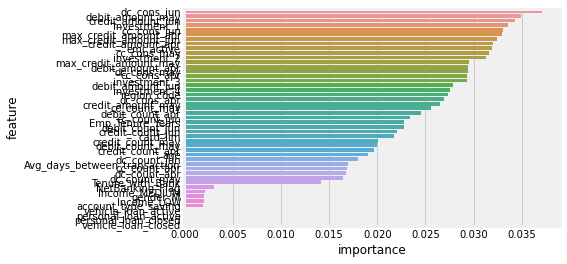

In [305]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_x.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_x.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]
sns.barplot( y = 'feature', x = 'importance', data = feature_rank )

##### As above graph is not clear so we will use below method.

In [306]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_x.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_x.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]

feature_rank

,rank,feature,importance
0,1,dc_cons_jun,0.037106
1,2,debit_amount_may,0.034918
2,3,credit_amount_jun,0.034258
3,4,investment_1,0.033522
4,5,cc_cons_jun,0.033067
5,6,max_credit_amount_apr,0.032882
6,7,max_credit_amount_jun,0.032405
7,8,credit_amount_apr,0.032004
8,9,emi_active,0.031931
9,10,cc_cons_may,0.031549


In [307]:
#Select features and then convert it into list
x=feature_rank.loc[0:75,['feature']]
x=x['feature'].tolist()
print(x)

['dc_cons_jun', 'debit_amount_may', 'credit_amount_jun', 'investment_1', 'cc_cons_jun', 'max_credit_amount_apr', 'max_credit_amount_jun', 'credit_amount_apr', 'emi_active', 'cc_cons_may', 'investment_2', 'max_credit_amount_may', 'debit_amount_apr', 'dc_cons_may', 'cc_cons_apr', 'investment_3', 'debit_amount_jun', 'investment_4', 'region_code', 'dc_cons_apr', 'credit_amount_may', 'cc_count_may', 'debit_count_apr', 'cc_count_jun', 'Emp_Tenure_Years', 'debit_count_jun', 'credit_count_jun', 'card_lim', 'credit_count_may', 'debit_count_may', 'credit_count_apr', 'age', 'dc_count_jun', 'Avg_days_between_transaction', 'cc_count_apr', 'dc_count_apr', 'dc_count_may', 'Tenure_with_Bank', 'NetBanking_Flag', 'Income_MEDIUM', 'gender_M', 'Income_LOW', 'account_type_saving', 'vehicle_loan_active', 'personal_loan_active', 'personal_loan_closed', 'vehicle_loan_closed']


In [308]:
# Create data frame with selected features
rf_features=['emi_active', 'cc_cons_may', 'cc_cons_apr', 'cc_cons_jun', 'max_credit_amount_jun', 
             'investment_1', 'debit_amount_may', 'credit_amount_apr', 'max_credit_amount_apr', 
             'dc_cons_jun', 'dc_cons_apr', 'debit_amount_jun', 'max_credit_amount_may',
             'credit_amount_jun', 'debit_amount_apr', 'credit_amount_may', 'dc_cons_may', 
             'investment_3', 'investment_2', 'Emp_Tenure_Years', 'card_lim', 'region_code', 'investment_4',
             'cc_count_jun', 
             'debit_count_jun', 'debit_count_apr', 'cc_count_may', 'debit_count_may', 'age', 'credit_count_may', 
             'credit_count_jun', 'Avg_days_between_transaction', 'dc_count_jun', 'cc_count_apr', 'dc_count_may', 
             'dc_count_apr', 'credit_count_apr', 'Tenure_with_Bank', 'NetBanking_Flag', 'account_type_saving',
             'Income_LOW', 'gender_M', 
             'Income_MEDIUM', 'vehicle_loan_active', 'personal_loan_active', 'personal_loan_closed', 'vehicle_loan_closed']
rf_features.append('cc_cons')
df_rf= credit_spend_existing_fin[rf_features]

df_rf.head(5)

,emi_active,cc_cons_may,cc_cons_apr,cc_cons_jun,max_credit_amount_jun,investment_1,debit_amount_may,credit_amount_apr,max_credit_amount_apr,dc_cons_jun,dc_cons_apr,debit_amount_jun,max_credit_amount_may,credit_amount_jun,debit_amount_apr,credit_amount_may,dc_cons_may,investment_3,investment_2,Emp_Tenure_Years,card_lim,region_code,investment_4,cc_count_jun,debit_count_jun,debit_count_apr,cc_count_may,debit_count_may,age,credit_count_may,credit_count_jun,Avg_days_between_transaction,dc_count_jun,cc_count_apr,dc_count_may,dc_count_apr,credit_count_apr,Tenure_with_Bank,NetBanking_Flag,account_type_saving,Income_LOW,gender_M,Income_MEDIUM,vehicle_loan_active,personal_loan_active,personal_loan_closed,vehicle_loan_closed,cc_cons
0,1674.09,10288.00,24893.00,16291.40,50836.0,593.20,11527.50,25192.00,25296.0,11432.00,378.00,30051.32,24563.0,12761.0,85919.48,191777.13,29664.00,787.0,1244.14,15.0,430000.0,708.0,6885.0,10.0,65.0,24.0,26.0,40.0,35.0,2.0,2,17.0,47,2.0,14.0,48.0,6.0,1,0,0,0,1,1,1,1,1.0,1,20014.0
1,13043.34,20672.00,18941.62,4217.00,23226.0,213557.15,92276.57,88693.37,80750.0,885.00,966.00,42119.05,23948.0,76206.0,12255.75,71162.00,287.00,90525.0,172678.56,15.0,127500.0,233.0,1500.0,13.0,63.0,35.0,7.0,78.0,35.0,2.0,21,14.0,31,1.0,21.0,3.0,36.0,6,0,0,0,1,0,1,1,1.0,1,10173.0
2,25375.27,1964.50,5678.87,23956.25,27036.0,165907.57,19343.00,84880.00,38466.0,5168.00,2724.00,58373.25,10752.0,75283.0,34193.00,70978.00,3933.11,25524.0,470000.00,24.5,199999.0,802.0,3735.0,102.0,1.0,72.0,32.0,82.0,55.0,2.0,7,3.0,80,43.0,1.0,4.0,9.0,1,1,0,0,1,1,1,1,1.0,1,16095.0
3,3544.33,12609.88,30489.50,17521.00,43037.0,81872.65,43867.91,236326.00,52732.0,13650.30,1236.00,69851.51,12607.0,68708.0,11558.23,63033.84,9138.14,48500.0,223379.40,4.5,155000.0,867.0,-4679.0,50.0,83.0,43.0,1.0,38.0,29.0,23.0,21,4.0,10,53.0,1.0,1.0,30.0,6,1,0,0,0,1,1,1,1.0,1,7707.0
4,12780.44,4364.00,7441.40,2121.00,32044.0,568.80,153253.71,58897.03,19613.0,6829.18,6906.04,10071.00,25213.0,80140.0,17022.81,30286.00,1939.00,183999.0,385000.00,12.6,297000.0,802.0,6916.0,82.0,32.0,46.0,47.0,50.0,34.0,24.0,8,7.0,68,67.0,16.0,54.0,36.0,4,1,0,0,1,1,1,1,1.0,1,96408.0


# Visualizing a Single Decision Tree
One of the coolest parts of the Random Forest implementation in Skicit-learn is we can actually examine any of the trees in the forest. We will select one tree, and save the whole tree as an image.
The following code takes one tree from the forest and saves it as an image.

In [309]:
feature_list = list(df_rf.columns)

In [310]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = radm_clf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = radm_clf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_columns, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [311]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_x, train_y)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_columns, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

# Variable Importances ( Method :2)
In order to quantify the usefulness of all the variables in the entire random forest, we can look at the relative importances of the variables. The importances returned in Skicit-learn represent how much including a particular variable improves the prediction. we can use the numbers to make relative comparisons between variables.


In [312]:
# Get numerical feature importances
importances = list(radm_clf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(credit_spend_existing_fin, round(importance, 5)) for credit_spend_existing_fin, importance in zip(feature_columns, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: dc_cons_jun          Importance: 0.03711
Variable: debit_amount_may     Importance: 0.03492
Variable: credit_amount_jun    Importance: 0.03426
Variable: investment_1         Importance: 0.03352
Variable: cc_cons_jun          Importance: 0.03307
Variable: max_credit_amount_apr Importance: 0.03288
Variable: max_credit_amount_jun Importance: 0.03241
Variable: credit_amount_apr    Importance: 0.032
Variable: emi_active           Importance: 0.03193
Variable: cc_cons_may          Importance: 0.03155
Variable: investment_2         Importance: 0.03125
Variable: max_credit_amount_may Importance: 0.02946
Variable: debit_amount_apr     Importance: 0.02944
Variable: dc_cons_may          Importance: 0.02937
Variable: cc_cons_apr          Importance: 0.02934
Variable: investment_3         Importance: 0.02928
Variable: debit_amount_jun     Importance: 0.02787
Variable: investment_4         Importance: 0.02759
Variable: region_code          Importance: 0.02733
Variable: dc_cons_apr         

# Visualizations

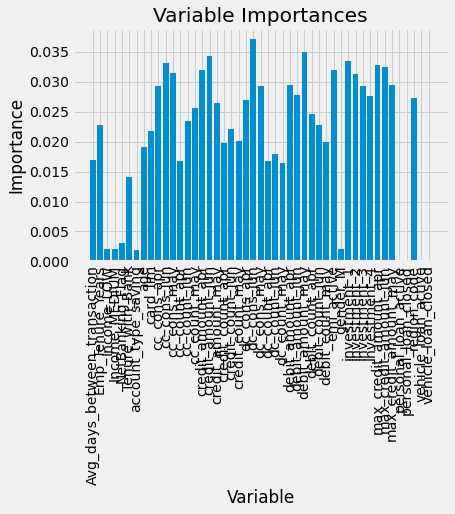

In [313]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_columns, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### As model is made successfully and tested also, now for our sake of knowledge we will still see the remaining assumption of the linear regression.

## Check - 2: Find multicolinearlity : using VIF 

In [314]:
import statsmodels as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

In [315]:
del rf_features[-1]

In [316]:
df_rf['ln_cc_cons']= np.log(df_rf['cc_cons']+1)
rf_features=df_rf.columns
rf_features

C:\Users\Vicky\AppData\Local\Temp/ipykernel_5324/1181543194.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rf['ln_cc_cons']= np.log(df_rf['cc_cons']+1)


Index(['emi_active', 'cc_cons_may', 'cc_cons_apr', 'cc_cons_jun', 'max_credit_amount_jun', 'investment_1', 'debit_amount_may', 'credit_amount_apr', 'max_credit_amount_apr', 'dc_cons_jun', 'dc_cons_apr', 'debit_amount_jun', 'max_credit_amount_may', 'credit_amount_jun', 'debit_amount_apr', 'credit_amount_may', 'dc_cons_may', 'investment_3', 'investment_2', 'Emp_Tenure_Years', 'card_lim', 'region_code', 'investment_4', 'cc_count_jun', 'debit_count_jun', 'debit_count_apr', 'cc_count_may', 'debit_count_may', 'age', 'credit_count_may', 'credit_count_jun', 'Avg_days_between_transaction', 'dc_count_jun', 'cc_count_apr', 'dc_count_may', 'dc_count_apr', 'credit_count_apr', 'Tenure_with_Bank', 'NetBanking_Flag', 'account_type_saving', 'Income_LOW', 'gender_M', 'Income_MEDIUM', 'vehicle_loan_active', 'personal_loan_active', 'personal_loan_closed', 'vehicle_loan_closed', 'cc_cons', 'ln_cc_cons'], dtype='object')

In [317]:
%%capture
#gather features
features = "+".join(rf_features)

In [318]:
features

'emi_active+cc_cons_may+cc_cons_apr+cc_cons_jun+max_credit_amount_jun+investment_1+debit_amount_may+credit_amount_apr+max_credit_amount_apr+dc_cons_jun+dc_cons_apr+debit_amount_jun+max_credit_amount_may+credit_amount_jun+debit_amount_apr+credit_amount_may+dc_cons_may+investment_3+investment_2+Emp_Tenure_Years+card_lim+region_code+investment_4+cc_count_jun+debit_count_jun+debit_count_apr+cc_count_may+debit_count_may+age+credit_count_may+credit_count_jun+Avg_days_between_transaction+dc_count_jun+cc_count_apr+dc_count_may+dc_count_apr+credit_count_apr+Tenure_with_Bank+NetBanking_Flag+account_type_saving+Income_LOW+gender_M+Income_MEDIUM+vehicle_loan_active+personal_loan_active+personal_loan_closed+vehicle_loan_closed+cc_cons+ln_cc_cons'

In [319]:
# get y and X dataframes based on this regression:
y, X = dmatrices('ln_cc_cons~' + features,df_rf, return_type='dataframe')

In [320]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns

C:\Users\Vicky\anaconda31\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


In [321]:
vif.sort_values(by=['VIF Factor'],ascending=False)

,VIF Factor,features
43,3.244121,Income_MEDIUM
41,3.243761,Income_LOW
49,3.156106,ln_cc_cons
48,3.154870,cc_cons
29,2.999633,age
20,2.998186,Emp_Tenure_Years
2,1.004655,cc_cons_may
25,1.004454,debit_count_jun
22,1.003855,region_code
17,1.003760,dc_cons_may


In [322]:
vif1=vif[vif['VIF Factor']<10].reset_index().loc[:,['features']]
vif1

,features
0,Intercept
1,emi_active
2,cc_cons_may
3,cc_cons_apr
4,cc_cons_jun
5,max_credit_amount_jun
6,investment_1
7,debit_amount_may
8,credit_amount_apr
9,max_credit_amount_apr


In [323]:
#Select only those features whose Vif is greater than 10.
#vif1=vif[vif['VIF Factor']>10].reset_index().loc[:,['features']]
#vif1.drop([0],axis=0,inplace=True)
#drop_vars= vif1["features"].tolist()
#drop_vars

In [324]:
# dropping variables that have VIF greater than 10
#df_rf.drop(drop_vars,axis=1,inplace=True)

In [325]:
df_rf.shape

(15000, 49)

## Check 3 - All x variables should have a linear relationship with Y

In [326]:
#sns.lmplot(x="income",y="bc_cc_cons",data=df_rf,aspect=5,scatter_kws={'alpha':0.5})

### To build model again splitting data for training and testing

In [327]:
# Dropping variables one at a time which have p-values greater than 5%
feature_columns=df_rf.columns.difference(['ln_cc_cons','Avg_days_between_transaction', 'Emp_Tenure_Years', 'Income_LOW', 'Income_MEDIUM',
                                          'NetBanking_Flag', 'Tenure_with_Bank', 'account_type_saving', 'age', 
                                          'card_lim', 'cc_cons', 'cc_cons_apr', 'cc_cons_jun', 'cc_cons_may', 'cc_count_apr', 'cc_count_jun',
                                          'cc_count_may', 'credit_amount_apr', 'credit_amount_jun', 'credit_amount_may', 'credit_count_apr', 
                                          'credit_count_jun', 'credit_count_may', 'dc_cons_apr', 'dc_cons_jun', 'dc_cons_may', 'dc_count_apr', 
                                          'dc_count_jun', 'dc_count_may', 'debit_amount_apr', 'debit_amount_jun', 'debit_amount_may', 'debit_count_apr',
                                          'debit_count_jun', 'debit_count_may', 'emi_active', 'gender_M', 'investment_1', 'investment_2', 'investment_3', 
                                          'investment_4', 'max_credit_amount_apr', 'max_credit_amount_jun', 'max_credit_amount_may', ])
print(list(feature_columns))

['personal_loan_active', 'personal_loan_closed', 'region_code', 'vehicle_loan_active', 'vehicle_loan_closed']


In [328]:
train_x,test_x,train_y,test_y=train_test_split(df_rf[feature_columns],
                                              df_rf['ln_cc_cons'],
                                               test_size=.2,
                                               random_state=123)

## Build Regression model using statsmodels.api

In [329]:
import statsmodels.api as sm

In [330]:
train_x = sm.add_constant(train_x)
test_x=sm.add_constant(test_x)
lm=sm.OLS(train_y,train_x).fit()

C:\Users\Vicky\anaconda31\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [331]:
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             ln_cc_cons   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9816
Date:                Tue, 24 Aug 2021   Prob (F-statistic):              0.322
Time:                        23:15:07   Log-Likelihood:                -22550.
No. Observations:               12000   AIC:                         4.510e+04
Df Residuals:                   11998   BIC:                         4.512e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
personal_loan_active     2.4229 

In [332]:
lm.pvalues.sort_values(ascending=False)

region_code             0.321833
personal_loan_active    0.000000
personal_loan_closed    0.000000
vehicle_loan_active     0.000000
vehicle_loan_closed     0.000000
dtype: float64

In [333]:
print('Parameters:', lm.params) # Find the parameters of x i.e Beta value
print('R2: ', lm.rsquared) # Find the r**2

Parameters: personal_loan_active    2.422876
personal_loan_closed    2.422876
region_code            -0.000066
vehicle_loan_active     2.422876
vehicle_loan_closed     2.422876
dtype: float64
R2:  8.180395700818632e-05


## Eveluation of model accuracy

In [334]:
test_pred=lm.predict(test_x)
train_pred=lm.predict(train_x)

from sklearn import metrics

print('MSE Test:',metrics.mean_squared_error(test_y,test_pred))
print('MSE Train:',metrics.mean_squared_error(train_y,train_pred))

MSE Test: 2.425444407617333
MSE Train: 2.510601420012037


In [335]:
print ('MAE:', metrics.mean_absolute_error(test_y, test_pred))
print ('MSE:', metrics.mean_squared_error(test_y, test_pred))
print ('RMSE:', np.sqrt(metrics.mean_squared_error(test_y, test_pred)))

MAE: 1.1337071834027301
MSE: 2.425444407617333
RMSE: 1.557383834389369


In [336]:
MAPE_train = '%.3f' % np.mean(np.abs(train_y-train_pred)/(train_y))
MAPE_test = '%.3f' % np.mean(np.abs(test_y-test_pred)/(test_y))

# print the values of MAPE for train and test
print('MAPE of training data: ', MAPE_train,  ' | ', 'MAPE of testing data: ', MAPE_test)

MAPE of training data:  0.124  |  MAPE of testing data:  0.121


## Check  4: Normality of Residuals

## We will use Q-Q plot to examine this

C:\Users\Vicky\anaconda31\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

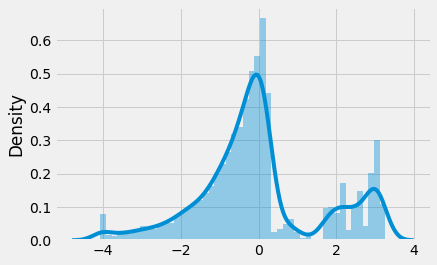

In [337]:
residuals=train_y-train_pred

import seaborn as sns

sns.distplot(residuals)

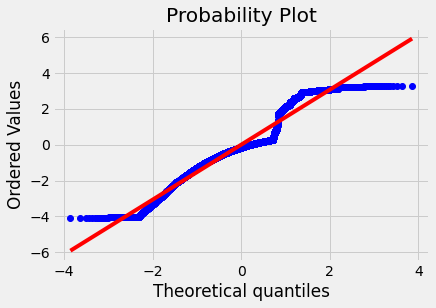

In [338]:
from scipy import stats
import pylab

stats.probplot(residuals,dist='norm',plot=pylab)
pylab.show()

##### From the above histogram and Q-Q plot, shows that the residuals are normally distributed, so our assumption is not violated

In [339]:
## As a final note, on this datasets we make Random Forest Regressor model as our target variable is not normally 
# distributed. 

In [340]:
##################End######################

## THANK YOU